# Attempting to correlate Keq data (both experimental and predicted from the numerical Derjaguin model)
- Are the experimental data correlated with protein structural attributes?
- Why is the electrostatics model overpredicting the retention of ADH and CAT? Can it be justified by the spherical charge distributions used in the model?

In [5]:
import platform
from pathlib import Path

import os
import subprocess
import time

import numpy as np
import scipy
from scipy import optimize
import pandas as pd # I added as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from addict import Dict
import json

# Temporary files for simulation objects
import tempfile
tempfile.tempdir = os.path.join(Path.home())

# IPython
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image
from ipywidgets import interact, interactive
import ipywidgets as widgets

import copy
from biopandas.pdb import PandasPdb


In [6]:
# General
def first_moment(time, absorbance):
    total_num = 0
    total_den = 0
    for element in range(len(time)):
        if element==0:
            pass
        elif absorbance[element] > 0:
            total_num   += absorbance[element]*(time[element] - time[element-1])*time[element]
            total_den   += absorbance[element]*(time[element] - time[element-1])
    return total_num/total_den

In [7]:
# From parameter correlation, pH 7
def cond_2_tis(cond):
    tis = (0.0229207306*(cond**2) + 9.3999636424*cond + 21.2424910935)
    return tis

def my_fit_function_keq(tis, a, b, c):
    return c*np.exp(a*(tis)**b)
def my_fit_function_keq_2(tis, a, b):
    return a*tis**b

def my_fit_function_ln_keq(tis, a, b, c):
    return np.log(c*np.exp(a*(tis)**b))
def my_fit_function_ln_keq_2(tis, a, b):
    return np.log(a*tis**b)

def get_fit_param_inputs():
    data_file    = pd.ExcelFile('aex_pH_7_all_data.xlsx') # Change here
    protein_list = ['adh', 'blg', 'cat', 'ova'] 
    return data_file, protein_list

def get_fit_params(protein, resin):
    tab_name = protein + '_' + resin
    data_file, protein_list = get_fit_param_inputs()
    
    df = pd.read_excel(data_file, tab_name)
    df.drop(['k_a*q_max', 'Ds_old', 'Keq_error', 'Ds', 'Ds_error'], axis=1, 
            inplace=True)
    df.dropna(inplace=True)
    return df
    
def get_correlation(resin, keq_correlation_function=my_fit_function_ln_keq):
    data_file, protein_list = get_fit_param_inputs()

    keq_fit_params = []
    Ds_fit_params = []

    for protein in protein_list:
        df = get_fit_params(protein, resin)
        try:
            if keq_correlation_function == my_fit_function_ln_keq:
                fit_keq = optimize.curve_fit(keq_correlation_function, df['IS (M)']*1e3,
                          np.log(df['Keq']), p0=(0.0, -1.0, 1.0e-2), maxfev=10000)
            elif keq_correlation_function == my_fit_function_ln_keq_2:
                fit_keq = optimize.curve_fit(keq_correlation_function, df['IS (M)']*1e3,
                          np.log(df['Keq']), p0=(1.0e-2, 1.0), maxfev=10000)
            keq_fit_params.append(fit_keq[0])
        except:
            print(f'We have a problem with {protein}')
            if keq_correlation_function == my_fit_function_ln_keq:
                keq_fit_params.append([0, 0, 0])
            elif keq_correlation_function == my_fit_function_ln_keq_2:
                keq_fit_params.append([0, 0])
    return keq_fit_params


def plot_keq(resin, keq_correlation_function=my_fit_function_keq):
    keq_fit_params = get_correlation(resin, keq_correlation_function)
    data_file, protein_list = get_fit_param_inputs()
    tis_new = np.linspace(50, 500, 1000)

    params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6, forward=True)
    ax.set_xlabel('Ionic Strength [mM]')
    ax.set_ylabel(r'Fit K$_{eq}$ [-]')
    ax.set_ylim(0.1, 100)

    for i, protein in enumerate(protein_list):
        df = get_fit_params(protein, resin)
        fit_params = keq_fit_params[i]
        
        if keq_correlation_function == my_fit_function_ln_keq:
            keq_new = [np.exp(keq_correlation_function(tis, fit_params[0], fit_params[1],
            fit_params[2])) for tis in tis_new]
        elif keq_correlation_function == my_fit_function_ln_keq_2: 
            keq_new = [np.exp(keq_correlation_function(tis, fit_params[0], fit_params[1])) 
                       for tis in tis_new]
            
        ax.loglog(df['IS (M)']*1e3, df['Keq'], 'o', label=protein)
        ax.loglog(tis_new, keq_new, color=plt.gca().lines[-1].get_color())

    ax.legend(loc='best', frameon=False, handlelength=1.0)
    plt.show()
    return keq_fit_params, fig

In [8]:
def meta_correlation(a, c, d):
    return c*np.log(a) + d

# Depth of charged atoms in protein structures

In [5]:
prot_folders = os.listdir('pqr_structure_files')
prot_folders.sort()

In [6]:
dfs_pqr = {} # .pqr file (protein structure)
dfs_dep = {} # Depths of each atom in the pqr file beneath the VdW surface
dfs_sph_pqr = {} # Discrete charges from .pqr file projected onto sphere
                 # (i.e. nonzero charges as summed for each residue)

for f in prot_folders:
    if f[:3] == 'lys':
        pass
    else:
        # In this format, BioPandas loads the partial charge into the occupancy column
        dfs_pqr[f] = PandasPdb().read_pdb('./pqr_structure_files/' + f + '/pqr.pqr')
        dfs_dep[f] = pd.read_fwf('./pqr_structure_files/' + f + '/pqr_atom.dep')
        dfs_sph_pqr[f] = pd.read_csv('ns_bim_spherical_pqr/charges/' + f + '/pqr_charges.csv')


In [7]:
charged_ox = ['OXT', 'OE1', 'OE2', 'OD1', 'OD2'] # 'SG'
dfs_negative_atoms = {}

for f in prot_folders:
    if f[:3] == 'lys':
        pass
    else:
    
        temp = []
        i_ind = 0
        df = dfs_pqr[f].df['ATOM'].copy()
        
        for j, jcont in dfs_sph_pqr[f].iterrows():
            if jcont['q'] == -1.0:
                for i, icont in df.iloc[i_ind:].iterrows():
                    if jcont['res_num'] == icont['residue_number'] and \
                    icont['atom_name'] in charged_ox:
                        temp.append([icont['residue_name'], icont['atom_number'], 
                                     icont['atom_name'], jcont['q'],])
                        i_ind = i
                        # This only picks out one of the two O atoms
                        break
        
        df_negative_atoms = pd.DataFrame(temp, columns=['res_name', 'atom_num', 
                                                'atom_name', 'q'])
        
        # Some terminal residues have +1 and -1 charges and weren't included in the 
        # file of .pqr charge spherical projections; this catches them
        for i, icont in df.iterrows():
            if icont['atom_name'] == 'OXT' and \
            icont['atom_number'] not in list(df_negative_atoms['atom_num']):
                df_negative_atoms.loc[len(df_negative_atoms)] = [icont['residue_name'], 
                icont['atom_number'], icont['atom_name'], jcont['q']]
            
        dfs_negative_atoms[f] = df_negative_atoms
        print(df_negative_atoms.tail(), '\n')

    res_name  atom_num atom_name    q
140      ASP     20668       OD1 -1.0
141      LYS      5140       OXT  2.0
142      LYS     10344       OXT  2.0
143      LYS     15504       OXT  2.0
144      LYS     20708       OXT  2.0 

   res_name  atom_num atom_name    q
49      GLU      4532       OE1 -1.0
50      ASP      4588       OD1 -1.0
51      GLU      4922       OE1 -1.0
52      GLU      4937       OE1 -1.0
53      CYS      4969       OXT -1.0 

    res_name  atom_num atom_name    q
222      ASP     31511       OD1 -1.0
223      GLU      7859       OXT  2.0
224      GLU     15767       OXT  2.0
225      GLU     23673       OXT  2.0
226      GLU     31583       OXT  2.0 

   res_name  atom_num atom_name    q
37      GLU      5391       OE1 -1.0
38      ASP      5438       OD1 -1.0
39      GLU      5509       OE1 -1.0
40      ASP      5592       OD1 -1.0
41      PRO      5975       OXT -1.0 



In [8]:
# Check the C terminii were appropriately included
for f in prot_folders:
    if f[:3] != 'lys':
        print(list(dfs_negative_atoms[f]['atom_name']).count('OXT'))

4
2
4
1


In [9]:
# Get depths of negatively charged atoms; note I believe 2.88 A means an O atom is on the surface
for f in prot_folders:
    if f[:3] != 'lys':
        for i, icont in dfs_negative_atoms[f].iterrows():
            dfs_negative_atoms[f].at[i, 'depth'] =\
            dfs_dep[f].loc[dfs_dep[f]['atom#'] == icont['atom_num'], 'depth'].iloc[0]

In [10]:
# Check appropriate charges have been identified; note I'm intentionally not including 
# S- charges here, which explains the discrepancy
for f in prot_folders:
    if f[:3] != 'lys':
        print(len(dfs_negative_atoms[f]), list(dfs_sph_pqr[f]['q']).count(-1.0))
        print(list(dfs_negative_atoms[f]['res_name']).count('ASP'), list(dfs_sph_pqr[f]['residue']).count('ASP'))
        print(list(dfs_negative_atoms[f]['res_name']).count('GLU'), list(dfs_sph_pqr[f]['residue']).count('GLU'))
        print(list(dfs_negative_atoms[f]['res_name']).count('CYS'), list(dfs_sph_pqr[f]['residue']).count('CYS'))
        print()


145 149
62 62
79 79
0 8

54 54
20 20
32 32
2 2

227 223
134 134
93 93
0 0

42 42
13 13
28 28
0 0



## Cumulative negative charge vs. depth

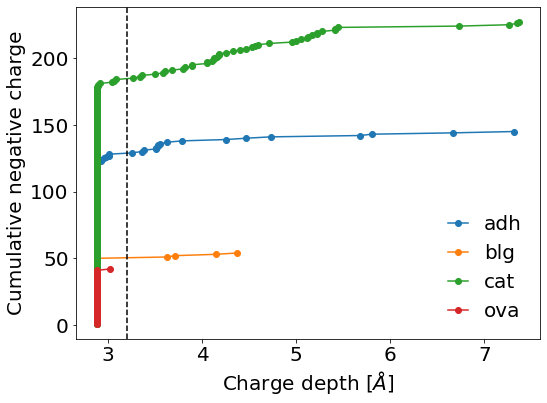

In [11]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Charge depth [$\AA$]')
ax.set_ylabel('Cumulative negative charge')

num_surf = []
total_neg = []
x_thresh = 3.2

for f in prot_folders:
    if f[:3] != 'lys':
        depths = list(dfs_negative_atoms[f]['depth'])
        depths.sort()
        threshold = next((x for x in depths if x > x_thresh), depths[-1])
        num_surf.append(depths.index(threshold) + 1)
        total_neg.append(len(depths))
        
        p = np.arange(len(depths)) + 1.0
        ax.plot(depths, p, linestyle='-', marker='o', label=f[:3])

ax.axvline(x=x_thresh, linestyle='--', color='black')
ax.legend(handlelength=1, frameon=False)
plt.tight_layout()

fig.savefig('./images/protein_characteristics/cumulative_negative_charge_vs_depth.png', dpi=300)

In [12]:
num_surf

[129, 51, 185, 42]

In [13]:
masses = [147.3968*4/4, 36.8*2/2, 59.915*4, 42.7]
areas = [49082.671, 13391.213, 65641.059, 14841.587] # From EDTSurf output

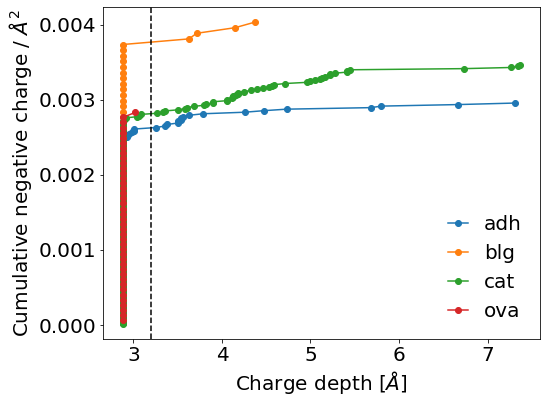

In [14]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()

fig.set_size_inches(8, 6, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Charge depth [$\AA$]')
ax.set_ylabel('Cumulative negative charge / $\AA^2$')

num_surf_per_area = []
x_thresh = 3.2
cnt = 0

for f in prot_folders:
    if f[:3] != 'lys':
        depths = list(dfs_negative_atoms[f]['depth'])
        depths.sort()
        threshold = next((x for x in depths if x > x_thresh), depths[-1])
        num_surf_per_area.append((depths.index(threshold) + 1)/areas[cnt])
        
        p = np.arange(len(depths)) + 1.0
        ax.plot(depths, p/areas[cnt], linestyle='-', marker='o', label=f[:3])
        cnt += 1

ax.axvline(x=x_thresh, linestyle='--', color='black')
ax.legend(handlelength=1, frameon=False)
plt.tight_layout()
fig.savefig('./images/protein_characteristics/cumulative_negative_charge_area_normalized_vs_depth.png', dpi=300)

In [15]:
num_surf_per_area

[0.002628218826966446,
 0.003808467537630833,
 0.0028183579427016863,
 0.002829886049247968]

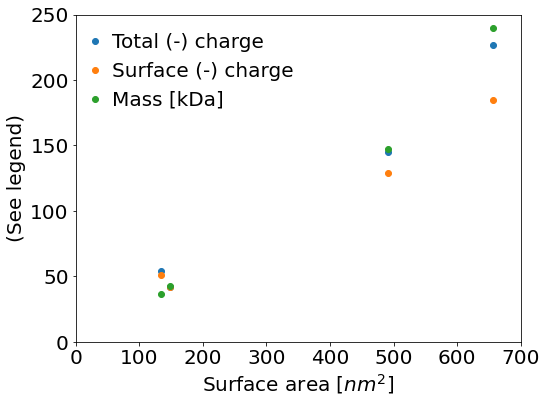

In [16]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)

ax.set_xlabel(r'Surface area [$nm^2$]')
ax.set_ylabel('(See legend)')

fig.patch.set_alpha(1.0)

ax.plot(np.array(areas)/100, total_neg, 'o', label='Total (-) charge')
ax.plot(np.array(areas)/100, num_surf, 'o', label='Surface (-) charge')
ax.plot(np.array(areas)/100, masses, 'o', label='Mass [kDa]')


ax.set_xlim(0, 700)
ax.set_ylim(0, 250)

ax.legend(loc='upper left', handlelength=0.1, frameon=False)
plt.tight_layout()
fig.savefig('./images/protein_characteristics/size_correlation.png', dpi=300, transparent=False)

In [214]:
total_charge = []

for f in prot_folders:
    if f[:3] != 'lys':
        total_charge.append(dfs_sph_pqr[f]['q'].sum())

mod_total_charge = total_charge.copy()
mod_total_charge[0] = mod_total_charge[0] + 4

total_charge_per_area = np.array(total_charge)/np.array(areas)
mod_total_charge_per_area = np.array(mod_total_charge)/np.array(areas)

(total_charge, mod_total_charge, total_charge_per_area, mod_total_charge_per_area)

([-3.0, -16.0, 0.0, -7.0],
 [1.0, -16.0, 0.0, -7.0],
 array([-6.11213681e-05, -1.19481335e-03,  0.00000000e+00, -4.71647675e-04]),
 array([ 2.03737894e-05, -1.19481335e-03,  0.00000000e+00, -4.71647675e-04]))

# Data and correlations using the 2-parameter 'linear' model
## Experimental (dimensional) Keq data (converting k' with phase ratios)
These data are from converting k' to Keq using protein-resin combination specific phase ratios. The Keq data are in [m]

In [8]:
dimensional_Keq_files = os.listdir('./experimental_data_kprime')

In [9]:
dim_Keq = {}
for f in dimensional_Keq_files:
    dim_Keq[f] = pd.read_csv('./experimental_data_kprime/' + f)

In [10]:
temp = []

for f in dimensional_Keq_files:
    df = dim_Keq[f]
    keq_fit_params = optimize.curve_fit(my_fit_function_ln_keq_2, df['IS(M)']*1e3,
                      np.log(df['Keq']), p0=(1, -50), maxfev=10000)
    temp.append([f, keq_fit_params[0][0], keq_fit_params[0][1]])

df_dim_Keq = pd.DataFrame(temp, columns=['file', 'a', 'b'])
df_dim_Keq

/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


file             a         b
0    lys_seph_pH5.csv  4.989469e+11 -7.280788
1     adh_phq_pH7.csv  8.522910e+00 -3.515679
2     ova_pxq_pH7.csv  7.096002e+06 -5.491151
3   mAbD_seph_pH7.csv  1.738005e+07 -6.408470
4     cat_pxq_pH7.csv  2.414861e+05 -4.932155
5     cat_phq_pH7.csv  6.313490e+02 -3.856346
6    lys_seph_pH9.csv  8.589650e+05 -5.587101
7     ova_phq_pH7.csv  8.621266e+03 -4.465863
8     adh_caq_pH7.csv  1.442079e-04 -1.532384
9     blg_pxq_pH7.csv  6.223262e+11 -7.183929
10    adh_pxq_pH7.csv  2.831660e+01 -3.573077
11    cat_caq_pH7.csv  1.335912e+03 -4.565047
12    blg_caq_pH7.csv  3.915647e+08 -6.326863
13    blg_phq_pH7.csv  3.892907e+11 -7.260876
14   lys_seph_pH7.csv  7.189905e+06 -5.556522
15    ova_caq_pH7.csv  1.280515e+05 -5.166430

In [12]:
resins = ['caq', 'phq', 'pxq']

for i, icont in df_dim_Keq.iterrows():
    f = icont['file']
    df_dim_Keq.at[i, 'protein'] = f[:f.find('_')]
    df_dim_Keq.at[i, 'resin'] = f[f.find('_')+1:f.find('_')+4]
    df_dim_Keq.at[i, 'pH'] = f[f.find('.')-1]

df_dim_Keq.sort_values(by=['resin', 'protein', 'pH'], inplace=True)
df_dim_Keq.reset_index(drop=True, inplace=True)
df_dim_Keq

file             a         b protein resin pH
0     adh_caq_pH7.csv  1.442079e-04 -1.532384     adh   caq  7
1     blg_caq_pH7.csv  3.915647e+08 -6.326863     blg   caq  7
2     cat_caq_pH7.csv  1.335912e+03 -4.565047     cat   caq  7
3     ova_caq_pH7.csv  1.280515e+05 -5.166430     ova   caq  7
4     adh_phq_pH7.csv  8.522910e+00 -3.515679     adh   phq  7
5     blg_phq_pH7.csv  3.892907e+11 -7.260876     blg   phq  7
6     cat_phq_pH7.csv  6.313490e+02 -3.856346     cat   phq  7
7     ova_phq_pH7.csv  8.621266e+03 -4.465863     ova   phq  7
8     adh_pxq_pH7.csv  2.831660e+01 -3.573077     adh   pxq  7
9     blg_pxq_pH7.csv  6.223262e+11 -7.183929     blg   pxq  7
10    cat_pxq_pH7.csv  2.414861e+05 -4.932155     cat   pxq  7
11    ova_pxq_pH7.csv  7.096002e+06 -5.491151     ova   pxq  7
12   lys_seph_pH5.csv  4.989469e+11 -7.280788     lys   sep  5
13   lys_seph_pH7.csv  7.189905e+06 -5.556522     lys   sep  7
14   lys_seph_pH9.csv  8.589650e+05 -5.587101     lys   sep  9
15  mAbD_seph_pH7.csv  1.738005e+07 -6.408470    mAbD   sep  7

In [13]:
# df_dim_Keq.to_csv('experimental_Keq_IS_correlation_params_dimensional_Keq.csv', index=False)

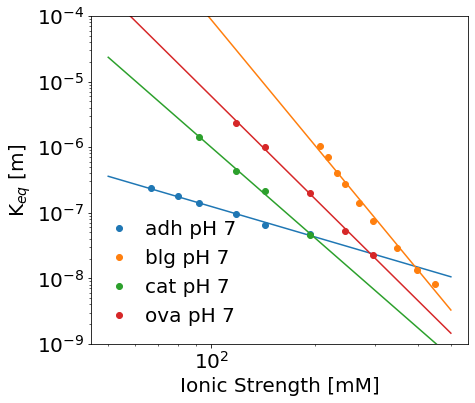

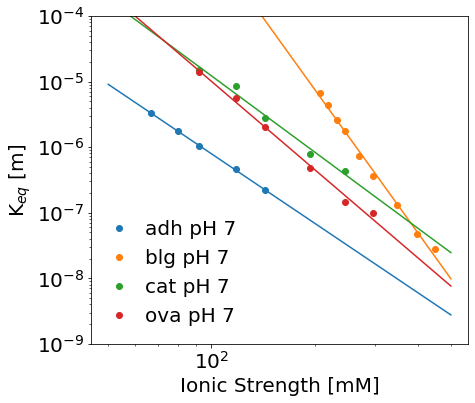

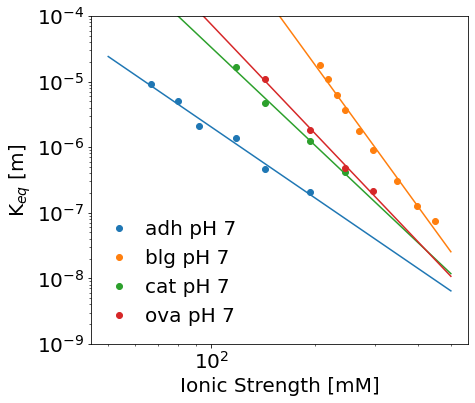

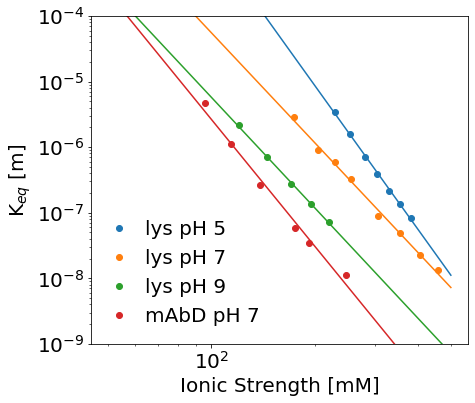

In [14]:
all_resins = ['caq', 'phq', 'pxq', 'sep']
tis_new = np.linspace(50, 500, 1000)

for res in all_resins:
    params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6, forward=True)
    fig.patch.set_alpha(1.0)
    ax.set_xlabel('Ionic Strength [mM]')
    ax.set_ylabel(r'K$_{eq}$ [m]')
    ax.set_ylim(1e-9, 1e-4)
    
    df_params = df_dim_Keq[df_dim_Keq['resin'] == res]
    for i, icont in df_params.iterrows():
        df = dim_Keq[icont['file']]
        label = icont['protein'] + ' pH ' + icont['pH']
        ax.loglog(df['IS(M)']*1e3, df['Keq'], 'o', label=label)

        a = icont['a']
        b = icont['b']
        keq_new = [np.exp(my_fit_function_ln_keq_2(tis, a, b)) for tis in tis_new]
        ax.loglog(tis_new, keq_new, color=plt.gca().lines[-1].get_color())

    ax.legend(loc='lower left', frameon=False, handlelength=1.0)
    plt.tight_layout()
#     fig.savefig('./images/Keq_dimensional_lin_correlation/' + res + '.png', dpi=300, 
#             bbox='tight', transparent=False)


### Meta-correlation

In [15]:
meta_fit = optimize.curve_fit(meta_correlation, df_dim_Keq['a'], df_dim_Keq['b'], 
                             p0=(-1.0, -1.0), maxfev=10000)
c, d = meta_fit[0][0], meta_fit[0][1]

In [16]:
c, d

(-0.15913410330945346, -3.120392034315302)

In [17]:
a_vals = np.logspace(-5, 13, 1000)
b_vals = [meta_correlation(a, meta_fit[0][0], meta_fit[0][1]) for a in a_vals]

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


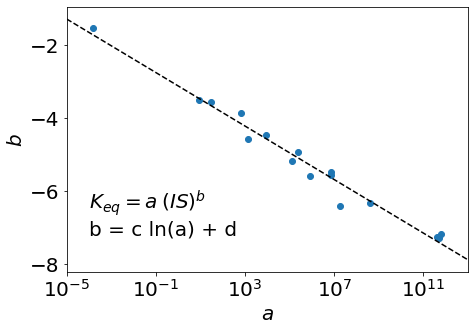

In [15]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

ax.scatter(df_dim_Keq['a'], df_dim_Keq['b'])
ax.plot(a_vals, b_vals, linestyle='--', color='black')

# df = df_dim_Keq[df_dim_Keq['protein']=='mAbD']
# ax.scatter(df['a'], df['b'], color='red', label='mAb D')

# ax.legend(loc='upper right', frameon=True, handlelength=0.5)
ax.text(x=1e-4, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
ax.text(x=1e-4, y=-7.2, s='b = c ln(a) + d')

ax.set_xscale('log')
ax.set_xlim(1e-5, 1e13)
plt.tight_layout()
fig.savefig('./images/meta_lin_correlation/data_dimensional_a_vs_b_no_mAb_highlight.png', dpi=300, 
            bbox='tight', transparent=False)

### Comparison of meta-correlation with experimental data in $K_{eq}$ - IS space

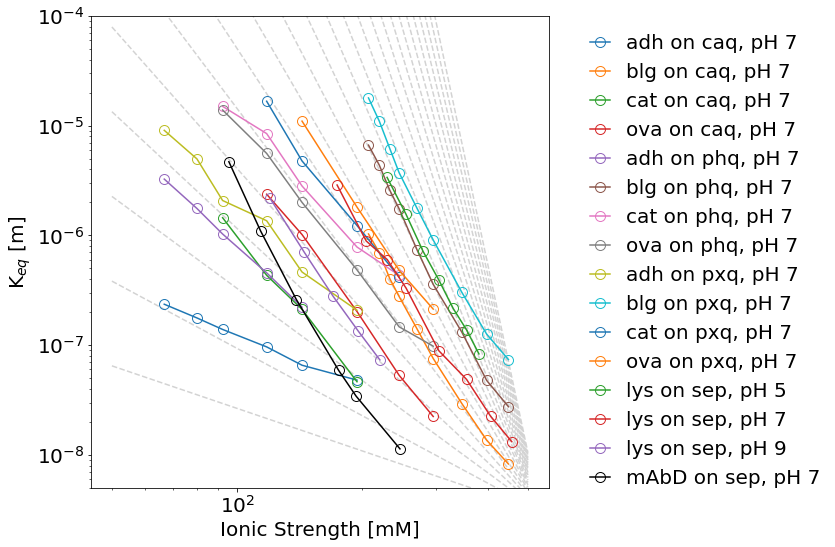

In [16]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(12, 8, forward=True)
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel(r'K$_{eq}$ [m]')
ax.set_ylim(5e-9, 1e-4)

a_vals = np.logspace(-5, 40, 23)
tis_new = np.linspace(50, 500, 1000)

for a in a_vals:
    b = meta_correlation(a, meta_fit[0][0], meta_fit[0][1])
    keq = [a*tis**b for tis in tis_new]
    ax.loglog(tis_new, keq, '--', color='lightgrey')

for i, icont in df_dim_Keq.iterrows():
    df = dim_Keq[icont['file']]
    df.sort_values(by=['IS(M)'], inplace=True)
    protein, resin, pH = icont['protein'], icont['resin'], icont['pH']
    label = f'{protein} on {resin}, pH {pH}'
    
    if icont['file'] == 'mAbD_seph_pH7.csv':
        ax.loglog(df['IS(M)']*1e3, df['Keq'], marker='o', fillstyle='none', markersize=10,
              label=label, color='black')
    else:
        ax.loglog(df['IS(M)']*1e3, df['Keq'], marker='o', fillstyle='none', markersize=10,
              label=label)

ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=False, handlelength=1.0)
plt.tight_layout()
# fig.savefig('./images/meta_lin_correlation/all_dimensonal_data.png', dpi=300, 
#             bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


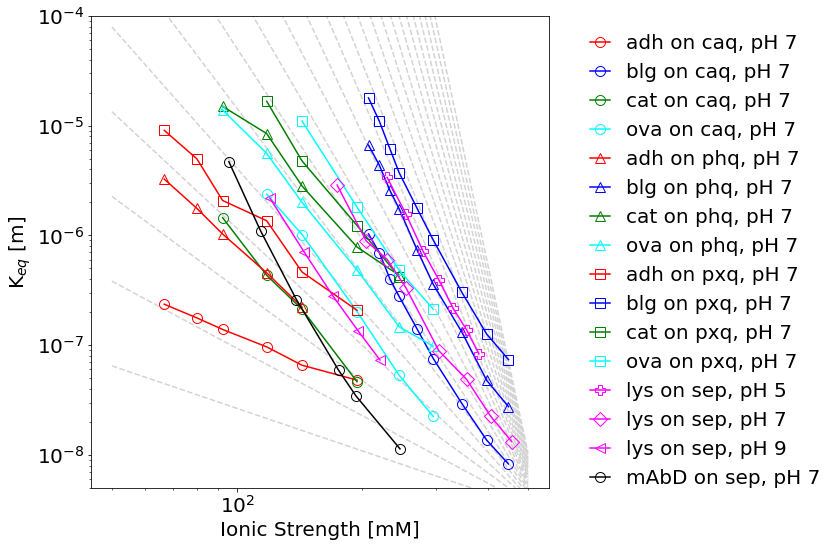

In [40]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(12, 8, forward=True)
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel(r'K$_{eq}$ [m]')
ax.set_ylim(5e-9, 1e-4)

a_vals = np.logspace(-5, 40, 23)
tis_new = np.linspace(50, 500, 1000)

for a in a_vals:
    b = meta_correlation(a, meta_fit[0][0], meta_fit[0][1])
    keq = [a*tis**b for tis in tis_new]
    ax.loglog(tis_new, keq, '--', color='lightgrey')

for i, icont in df_dim_Keq.iterrows():
    df = dim_Keq[icont['file']]
    df.sort_values(by=['IS(M)'], inplace=True)
    protein, resin, pH = icont['protein'], icont['resin'], icont['pH']
    label = f'{protein} on {resin}, pH {pH}'
    
    if icont['file'] == 'mAbD_seph_pH7.csv':
        ax.loglog(df['IS(M)']*1e3, df['Keq'], marker='o', fillstyle='none', markersize=10,
              label=label, color='black')
    else:
        protein, resin, pH = icont.protein, icont.resin, icont.pH
        
        if protein == 'adh':
            color = 'red'
        elif protein == 'blg':
            color = 'blue'
        elif protein == 'cat':
            color = 'green'
        elif protein == 'ova':
            color = 'cyan'
        else:
            color = 'magenta'
        
        if resin == 'caq':
            symbol = 'o'
        elif resin == 'phq':
            symbol = '^'
        elif resin == 'pxq':
            symbol = 's'  
        elif resin == 'sep':
            if pH == '5':
                symbol = 'P'
            elif pH == '7':
                symbol = 'D'
            elif pH == '9':
                symbol = '<'
            
        ax.loglog(df['IS(M)']*1e3, df['Keq'], marker=symbol, color=color, 
                  fillstyle='none', markersize=10, label=label)
        
ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=False, handlelength=1.0)
plt.tight_layout()
fig.savefig('./images/meta_lin_correlation/all_dimensonal_data_color_coded.png', dpi=300, 
            bbox='tight', transparent=False)

In [ ]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(11, 7, forward=True)
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel(r'K$_{eq}$ [-]')
ax.set_ylim(0.1, 100)

a_vals = np.logspace(1, 30, 30)
tis_new = np.linspace(50, 500, 1000)

for a in a_vals:
    b = meta_correlation(a, meta_fit[0][0], meta_fit[0][1])
    keq = [a*tis**b for tis in tis_new]
    ax.loglog(tis_new, keq, '--', color='lightgrey')

for j, protein in enumerate(protein_list):
    if j == 0:
        color = 'red'
    elif j == 1:
        color = 'blue'
    elif j == 2:
        color = 'green'
    elif j == 3:
        color = 'cyan'
    
    for i, resin in enumerate(resins):
        if i == 0:
            symbol = 'o'
        elif i == 1:
            symbol = '^'
        elif i == 2:
            symbol = 's'        
        
        df = get_fit_params(protein, resin)
        ax.loglog(df['IS (M)']*1e3, df['Keq'], marker=symbol, color=color, 
                  fillstyle='none', markersize=10, label=f'{protein} on {resin}')

ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=False, handlelength=1.0)
fig.savefig('./images/meta_lin_correlation/all_dimensionless_data.png', dpi=300, 
            bbox='tight', transparent=False)

### Just looking at behavior of meta-correlation

In [92]:
is_common = np.exp(-1.0/c)
Keq_common = np.exp(-1.0*d/c)
is_common, Keq_common
# Note Keq_common is also the value of a for which Keq doesn't change with IS

(535.9324583087906, 3.0486439943109677e-09)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


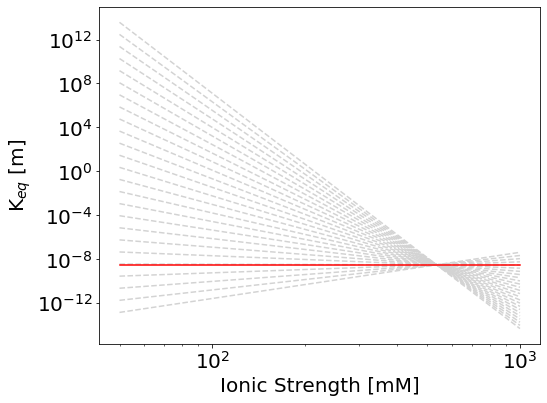

In [115]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel(r'K$_{eq}$ [m]')

# ax.set_xlim(520, 550)
# ax.set_ylim(2e-9, 5e-9)

a_vals = np.logspace(-20, 50, 25)
tis_new = np.linspace(50, 1000, 1000)

for a in a_vals:
    b = meta_correlation(a, meta_fit[0][0], meta_fit[0][1])
    keq = [a*tis**b for tis in tis_new]
    ax.loglog(tis_new, keq, '--', color='lightgrey')

b = meta_correlation(Keq_common, meta_fit[0][0], meta_fit[0][1])
keq = [Keq_common*tis**b for tis in tis_new]
ax.loglog(tis_new, keq, color='red')


plt.tight_layout()
fig.savefig('./images/meta_lin_correlation/just_meta_correlation_Keq_IS.png', dpi=300, 
            bbox='tight', transparent=False)

### Comparison of meta-correlation with DePhillip's data

In [62]:
lit_data_files = os.listdir('./lit_data/dephillips/cleaned_data/')

dfs_lit = {}
for file in lit_data_files:
    dfs_lit[file] = pd.read_csv(f'./lit_data/dephillips/cleaned_data/{file}')
    dfs_lit[file].rename(columns={'x':'NaCl (M)'}, inplace=True)
    
    # Convert log(Keq [nm]) to Keq [m]
    columns_list = dfs_lit[file].columns
    for column in columns_list:
        if column == 'NaCl (M)':
            pass
        else:
            dfs_lit[file][column] = 1e-9 * 10.0**(dfs_lit[file][column]) * 1e3
            # NOTE THE FACTOR OF 1e3 IS SCALING UP DEPHILLIP'S DATA due to what I
            # I believe to be a conversion error on his part
            
    # Estimate IS [mM]
    dfs_lit[file]['IS [mM]'] = dfs_lit[file]['NaCl (M)']*1e3 + 10

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


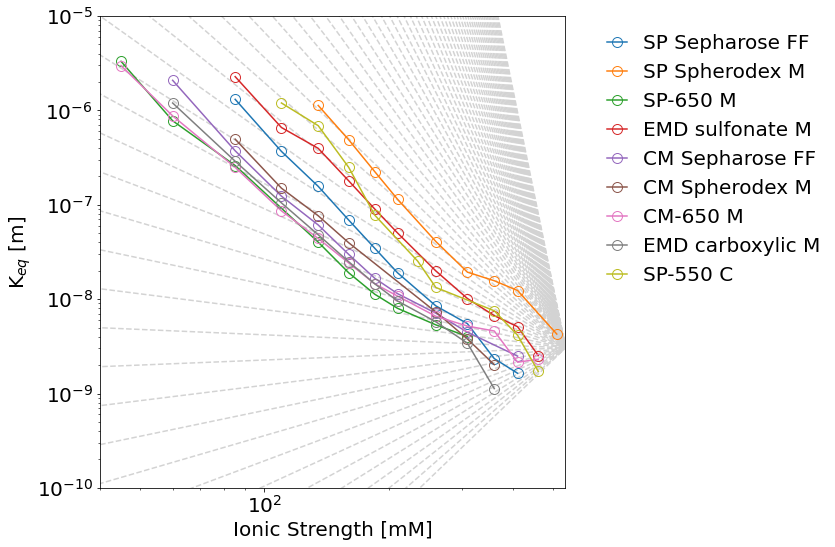

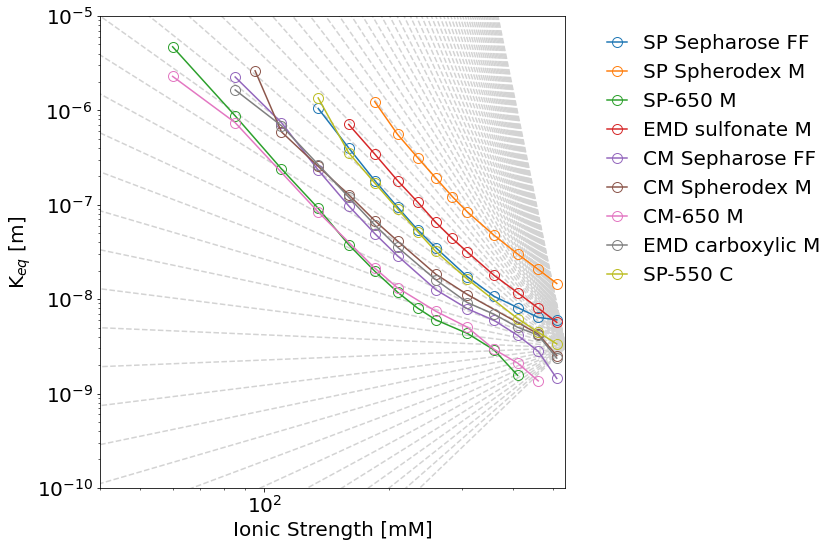

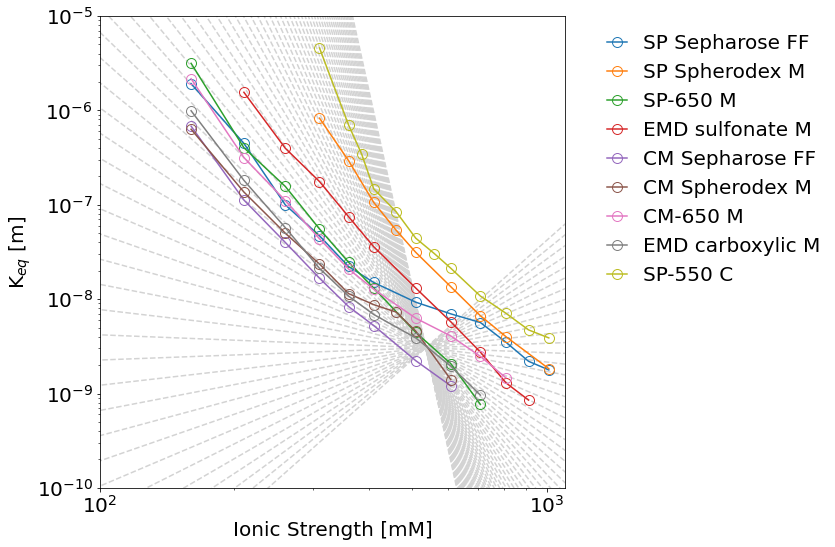

In [134]:
for file in lit_data_files:
    
    params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    fig.patch.set_alpha(1.0)
    fig.set_size_inches(12, 8, forward=True)
    ax.set_xlabel('Ionic Strength [mM]')
    ax.set_ylabel(r'K$_{eq}$ [m]')
    ax.set_ylim(1e-10, 1e-5)
    
    if file == 'lysozyme_mod.csv':
        tis_new = np.linspace(50, 1100, 1000)
        ax.set_xlim(100, 1100)
    else:
        tis_new = np.linspace(10, 535, 1000)
        ax.set_xlim(40, 535)
    
    a_vals = np.logspace(-20, 50, 71)
    for a in a_vals:
        b = meta_correlation(a, meta_fit[0][0], meta_fit[0][1])
        keq = [a*tis**b for tis in tis_new]
        ax.loglog(tis_new, keq, '--', color='lightgrey')
    
    df = dfs_lit[file]
    for column in columns_list:
        if column == 'NaCl (M)':
            pass
        else:
            mask = np.isfinite(df[column])
            ax.loglog(df['IS [mM]'][mask], df[column][mask], marker='o', 
                      fillstyle='none', markersize=10, label=column)

    ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=False, handlelength=1.0)
    plt.tight_layout()
    name = file[:file.find('_')]
    fig.savefig(f'./images/dephillips_data/comparison_to_Dephillips_{name}.png', 
                dpi=300, bbox='tight', transparent=False)

### Fitting $a, b$ to DePhillips data and comparing to my data

In [120]:
temp = []

for file in lit_data_files:
    df = dfs_lit[file]
    protein = file[:file.find('_')]
    
    for column in columns_list:
        if column != 'NaCl (M)':
            mask = np.isfinite(df[column]) 
            keq_fit_params = optimize.curve_fit(my_fit_function_ln_keq_2, 
                            df['IS [mM]'][mask], np.log(df[column][mask]), p0=(1, -50))
            temp.append([protein, column, keq_fit_params[0][0], keq_fit_params[0][1]])

df_lit_corr = pd.DataFrame(temp, columns=['protein', 'resin', 'a', 'b'])
df_lit_corr

/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


protein             resin             a         b
0            act   SP Sepharose FF  1.589229e+02 -4.232730
1            act    SP Spherodex M  4.678048e+02 -4.103294
2            act          SP-650 M  1.952469e+00 -3.575732
3            act   EMD sulfonate M  1.032699e+02 -3.988308
4            act   CM Sepharose FF  2.033086e+00 -3.499740
5            act    CM Spherodex M  6.116398e+00 -3.704238
6            act          CM-650 M  1.942484e-01 -3.058453
7            act  EMD carboxylic M  3.722159e+00 -3.685698
8            act          SP-550 C  1.961606e+03 -4.523748
9   cytochrome c   SP Sepharose FF  1.451071e+02 -3.922259
10  cytochrome c    SP Spherodex M  4.698306e+03 -4.282068
11  cytochrome c          SP-650 M  6.738330e+01 -4.132281
12  cytochrome c   EMD sulfonate M  7.568312e+02 -4.140702
13  cytochrome c   CM Sepharose FF  5.339128e+01 -3.916732
14  cytochrome c    CM Spherodex M  3.667429e+01 -3.796364
15  cytochrome c          CM-650 M  6.677464e+00 -3.675649
16  cytochrome c  EMD carboxylic M  1.327631e+01 -3.630167
17  cytochrome c          SP-550 C  1.126545e+03 -4.310715
18      lysozyme   SP Sepharose FF  3.679251e+01 -3.487689
19      lysozyme    SP Spherodex M  3.296456e+06 -5.134735
20      lysozyme          SP-650 M  1.481297e+06 -5.366744
21      lysozyme   EMD sulfonate M  7.312475e+05 -5.066773
22      lysozyme   CM Sepharose FF  8.290339e+03 -4.656898
23      lysozyme    CM Spherodex M  1.072005e+03 -4.244841
24      lysozyme          CM-650 M  2.586675e+03 -4.263284
25      lysozyme  EMD carboxylic M  4.291080e+03 -4.472676
26      lysozyme          SP-550 C  4.880648e+07 -5.461266

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


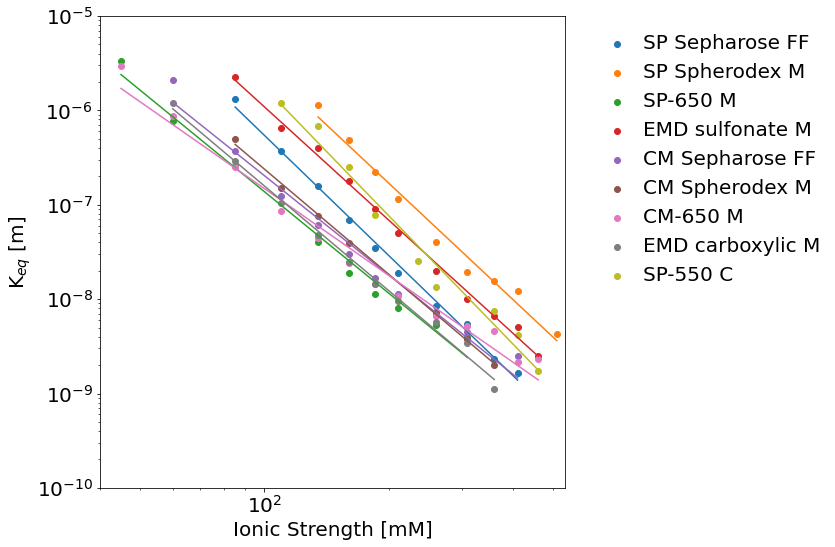

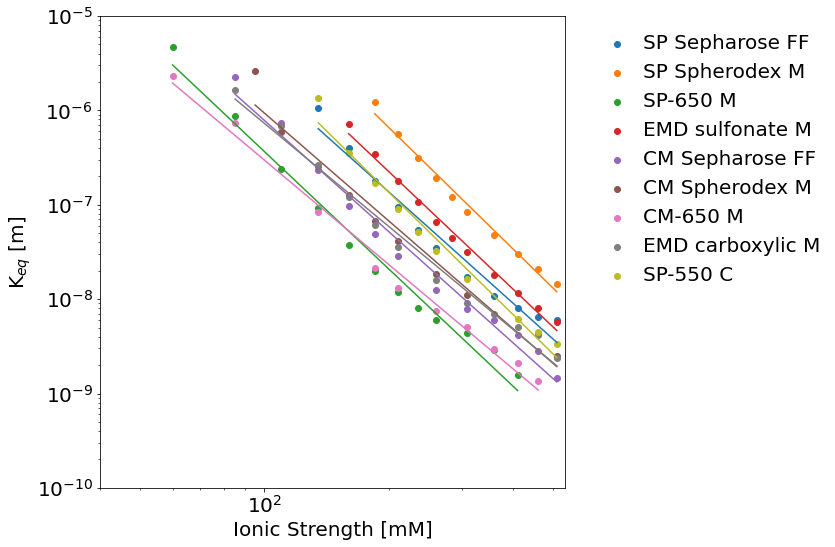

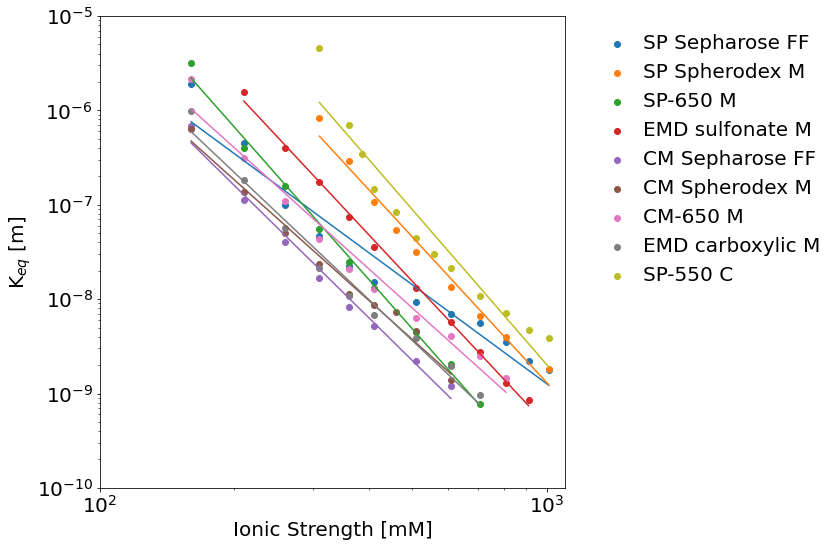

In [135]:
for file in lit_data_files:
    
    params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    fig.patch.set_alpha(1.0)
    fig.set_size_inches(12, 8, forward=True)
    ax.set_xlabel('Ionic Strength [mM]')
    ax.set_ylabel(r'K$_{eq}$ [m]')
    ax.set_ylim(1e-10, 1e-5)
    
    if file == 'lysozyme_mod.csv':
        ax.set_xlim(100, 1100)
    else:
        ax.set_xlim(40, 535)
    
    df = dfs_lit[file]
    protein = file[:file.find('_')]
    for column in columns_list:
        if column != 'NaCl (M)':
            mask = np.isfinite(df[column])
            ax.scatter(df['IS [mM]'][mask], df[column][mask], label=column)
            
            a = df_lit_corr.loc[(df_lit_corr['protein'] == protein) &\
                                (df_lit_corr['resin'] == column), 'a'].iloc[0]
            b = df_lit_corr.loc[(df_lit_corr['protein'] == protein) &\
                                (df_lit_corr['resin'] == column), 'b'].iloc[0]
            min_is = min(df['IS [mM]'][mask])
            max_is = max(df['IS [mM]'][mask])
            tis_new = [min_is, max_is]
            keq_new = [np.exp(my_fit_function_ln_keq_2(tis, a, b)) for tis in tis_new]       
            ax.loglog(tis_new, keq_new)
            
    ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=False, handlelength=1.0)
    plt.tight_layout()
    fig.savefig(f'./images/dephillips_data/lin_fit_of_{protein}_data.png', 
                dpi=300, bbox='tight', transparent=False)

In [138]:
dephillips_proteins = list(set(df_lit_corr['protein']))

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


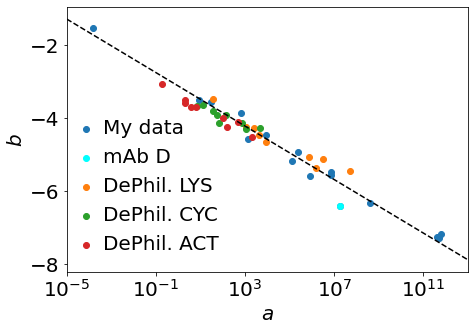

In [148]:
a_vals = np.logspace(-5, 13, 1000)
b_vals = [meta_correlation(a, meta_fit[0][0], meta_fit[0][1]) for a in a_vals]

params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

ax.scatter(df_dim_Keq['a'], df_dim_Keq['b'], label='My data')
ax.plot(a_vals, b_vals, linestyle='--', color='black')

df = df_dim_Keq[df_dim_Keq['protein']=='mAbD']
ax.scatter(df['a'], df['b'], color='cyan', label='mAb D')

for protein in dephillips_proteins:
    df = df_lit_corr[df_lit_corr['protein'] == protein]
    if protein == 'lysozyme':
        abbrev = 'LYS'
    elif protein == 'cytochrome c':
        abbrev = 'CYC'
    elif protein == 'act':
        abbrev = 'ACT'
    ax.scatter(df['a'], df['b'], label=f'DePhil. {abbrev}')

ax.legend(loc='lower left', frameon=False, handlelength=0.1)

ax.set_xscale('log')
ax.set_xlim(1e-5, 1e13)
plt.tight_layout()
fig.savefig('./images/dephillips_data/meta_correlation_comparison.png', dpi=300, 
            bbox='tight', transparent=False)

### How does the common $(IS, K_{eq})$ point change with each dataset?

In [151]:
def get_common_is_keq(c, d):
    is_common = np.exp(-1.0/c)
    Keq_common = np.exp(-1.0*d/c)
    return is_common, Keq_common

temp = []

meta_fit = optimize.curve_fit(meta_correlation, df_dim_Keq['a'], df_dim_Keq['b'], 
                             p0=(-1.0, -1.0))
c, d = meta_fit[0][0], meta_fit[0][1]
tis, keq = get_common_is_keq(c, d)
temp.append(['My data', c, d, tis, keq])

for protein in dephillips_proteins:
    df = df_lit_corr[df_lit_corr['protein'] == protein]
    meta_fit = optimize.curve_fit(meta_correlation, df['a'], df['b'], p0=(-1.0, -1.0))
    c, d = meta_fit[0][0], meta_fit[0][1]
    tis, keq = get_common_is_keq(c, d)
    
    if protein == 'lysozyme':
        abbrev = 'LYS'
    elif protein == 'cytochrome c':
        abbrev = 'CYC'
    elif protein == 'act':
        abbrev = 'ACT'
    label=f'DePhil. {abbrev}'
    
    temp.append([label, c, d, tis, keq])

df_common_pts = pd.DataFrame(temp, columns=['data_set', 'c', 'd', 'tis_common', 'keq_common'])
df_common_pts

data_set         c         d    tis_common    keq_common
0      My data -0.159134 -3.120392    535.932458  3.048644e-09
1  DePhil. LYS -0.134932 -3.240843   1654.269923  3.706827e-11
2  DePhil. CYC -0.105796 -3.468806  12735.010581  5.761768e-15
3  DePhil. ACT -0.140649 -3.408086   1224.003228  2.996203e-11

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


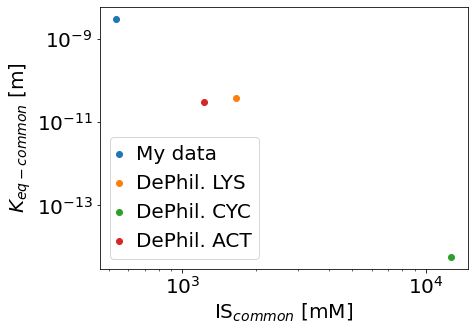

In [167]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('IS$_{common}$ [mM]')
ax.set_ylabel('$K_{eq-common}$ [m]')

ax.set_yscale('log')
ax.set_xscale('log')

for i, icont in df_common_pts.iterrows():
    ax.scatter([icont['tis_common']], [icont['keq_common']], label=icont['data_set'])

ax.legend(loc='lower left', frameon=True, handlelength=0.1)
fig.savefig('./images/dephillips_data/meta_correlation_comparison_common_points.png', dpi=300, 
            bbox='tight', transparent=False)

In [174]:
for file in lit_data_files:
    for i, icont in df_common_pts.iterrows():
        if file[:2].upper() in icont['data_set']:
            df_common_pts.at[i, 'file'] = file
        
df_common_pts

data_set         c         d    tis_common    keq_common  \
0      My data -0.159134 -3.120392    535.932458  3.048644e-09   
1  DePhil. LYS -0.134932 -3.240843   1654.269923  3.706827e-11   
2  DePhil. CYC -0.105796 -3.468806  12735.010581  5.761768e-15   
3  DePhil. ACT -0.140649 -3.408086   1224.003228  2.996203e-11   

                   file  
0                   NaN  
1      lysozyme_mod.csv  
2  cytochrome c_mod.csv  
3           act_mod.csv

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


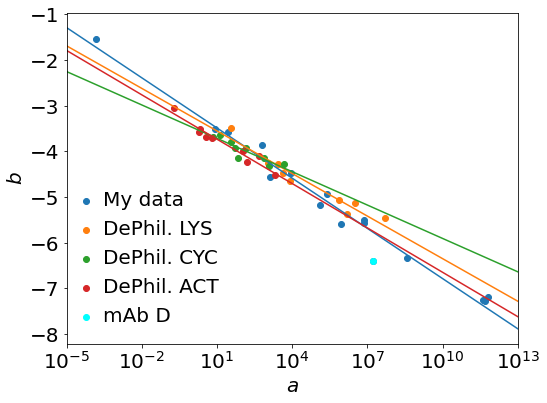

In [210]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

a_vals = np.logspace(-5, 13, 1000)

ax.scatter(df_dim_Keq['a'], df_dim_Keq['b'], label='My data')
b_vals = [meta_correlation(a, c, d) for a in a_vals]
ax.plot(a_vals, b_vals)

for protein in dephillips_proteins:
    df = df_lit_corr[df_lit_corr['protein'] == protein]
    if protein == 'lysozyme':
        abbrev = 'LYS'
    elif protein == 'cytochrome c':
        abbrev = 'CYC'
    elif protein == 'act':
        abbrev = 'ACT'
    
    label=f'DePhil. {abbrev}'
    ax.scatter(df['a'], df['b'], label=f'DePhil. {abbrev}')
    
    c = df_common_pts.loc[df_common_pts['data_set'] == label, 'c'].iloc[0]
    d = df_common_pts.loc[df_common_pts['data_set'] == label, 'd'].iloc[0]
    b_vals = [meta_correlation(a, c, d) for a in a_vals]
    ax.plot(a_vals, b_vals)

df = df_dim_Keq[df_dim_Keq['protein']=='mAbD']
ax.scatter(df['a'], df['b'], color='cyan', label='mAb D')

ax.legend(loc='lower left', frameon=False, handlelength=0.1)
ax.set_xscale('log')
ax.set_xlim(min(a_vals), max(a_vals))
plt.tight_layout()
fig.savefig('./images/dephillips_data/meta_correlation_comparison_all_data_set_correlations.png', dpi=300, 
            bbox='tight', transparent=False)

### How does each data set look against its own meta-correlation?

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


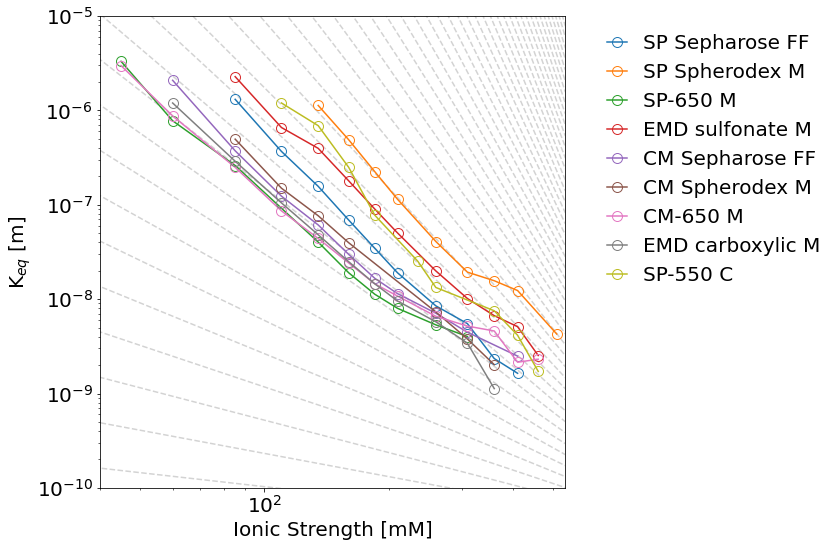

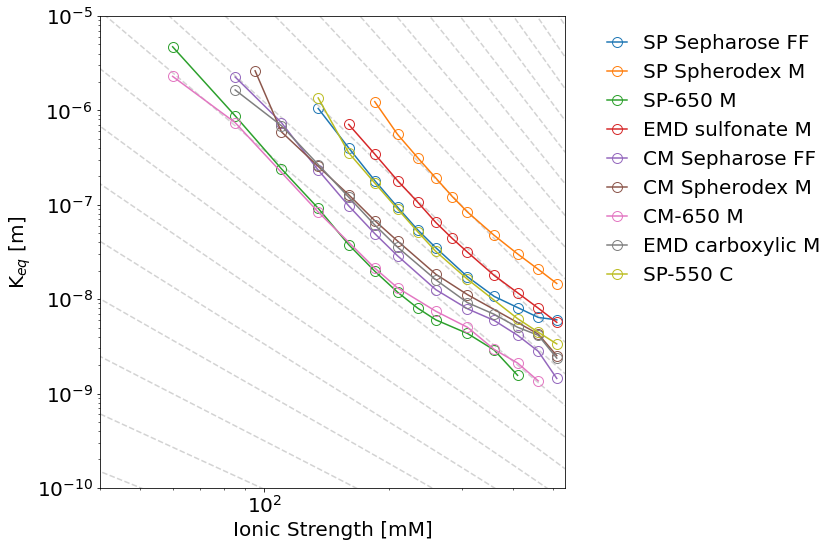

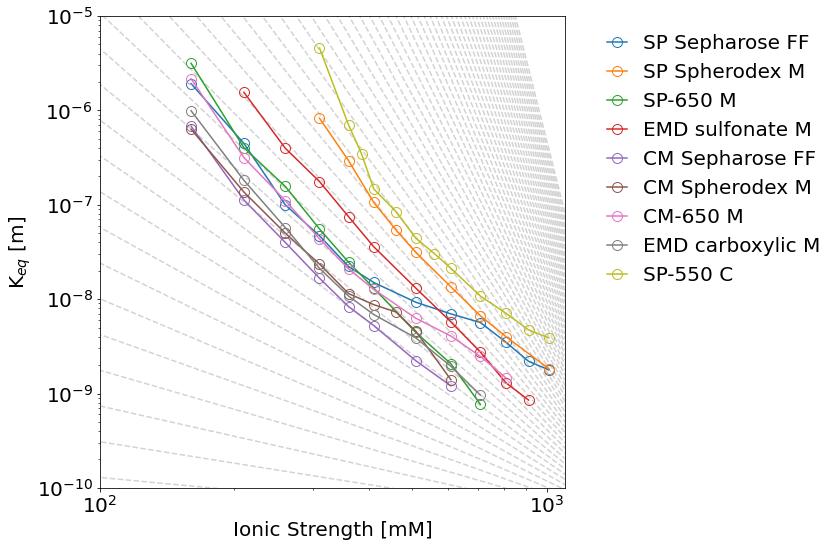

In [176]:
for file in lit_data_files:
    
    params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    fig.patch.set_alpha(1.0)
    fig.set_size_inches(12, 8, forward=True)
    ax.set_xlabel('Ionic Strength [mM]')
    ax.set_ylabel(r'K$_{eq}$ [m]')
    ax.set_ylim(1e-10, 1e-5)
    
    if file == 'lysozyme_mod.csv':
        tis_new = np.linspace(50, 1100, 1000)
        ax.set_xlim(100, 1100)
    else:
        tis_new = np.linspace(10, 535, 1000)
        ax.set_xlim(40, 535)
    
    a_vals = np.logspace(-20, 50, 71)
    c = df_common_pts.loc[df_common_pts['file'] == file, 'c'].iloc[0]
    d = df_common_pts.loc[df_common_pts['file'] == file, 'd'].iloc[0]
    
    for a in a_vals:
        b = meta_correlation(a, c, d)
        keq = [a*tis**b for tis in tis_new]
        ax.loglog(tis_new, keq, '--', color='lightgrey')
    
    df = dfs_lit[file]
    for column in columns_list:
        if column == 'NaCl (M)':
            pass
        else:
            mask = np.isfinite(df[column])
            ax.loglog(df['IS [mM]'][mask], df[column][mask], marker='o', 
                      fillstyle='none', markersize=10, label=column)

    ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=False, handlelength=1.0)
    plt.tight_layout()
    name = file[:file.find('_')]
    fig.savefig(f'./images/dephillips_data/Dephillips_{name}_with_its_meta_correlation.png', 
                dpi=300, bbox='tight', transparent=False)

### Meta-correlations for each resin

In [218]:
cex_resins = list(set(df_lit_corr['resin']))

In [219]:
temp = []
for resin in cex_resins:
    df = df_lit_corr[df_lit_corr['resin'] == resin]
    meta_fit = optimize.curve_fit(meta_correlation, df['a'], df['b'], p0=(-1.0, -1.0))
    c, d = meta_fit[0][0], meta_fit[0][1]
    tis, keq = get_common_is_keq(c, d)
    temp.append([resin, c, d, tis, keq])

df_resin_corr = pd.DataFrame(temp, columns=['resin', 'c', 'd', 'tis_common', 'keq_common'])
df_resin_corr

resin         c         d    tis_common    keq_common
0    CM Spherodex M -0.108296 -3.467873  10238.977856  1.238620e-14
1   SP Sepharose FF -0.425269 -1.945750     10.500812  1.030280e-02
2   EMD sulfonate M -0.125033 -3.366277   2974.586844  2.029946e-12
3    SP Spherodex M -0.119419 -3.327983   4332.531806  7.888310e-13
4          SP-550 C -0.101000 -3.677412  19950.088044  1.539326e-16
5          CM-650 M -0.123916 -3.330467   3196.960009  2.126123e-12
6          SP-650 M -0.130359 -3.528824   2145.462682  1.752468e-12
7   CM Sepharose FF -0.139834 -3.385414   1275.825277  3.059215e-11
8  EMD carboxylic M -0.122135 -3.430203   3596.332724  6.348625e-13

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


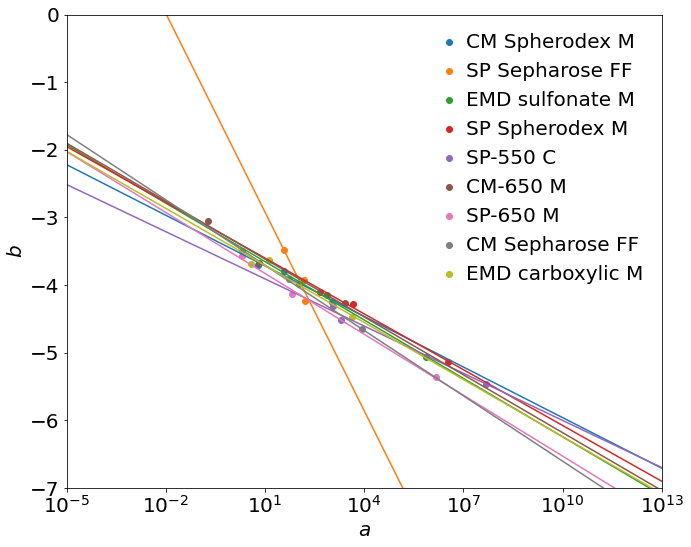

In [225]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(10, 8, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

a_vals = np.logspace(-5, 13, 1000)

for i, icont in df_resin_corr.iterrows():
    resin = icont['resin']
    df = df_lit_corr[df_lit_corr['resin'] == resin]
    ax.scatter(df['a'], df['b'], label=resin)
    
    c = icont['c']
    d = icont['d']
    b_vals = [meta_correlation(a, c, d) for a in a_vals]
    ax.plot(a_vals, b_vals)

ax.legend(loc='upper right', frameon=False, handlelength=0.1)
ax.set_xscale('log')
ax.set_xlim(min(a_vals), max(a_vals))
ax.set_ylim(-7, 0)
plt.tight_layout()
fig.savefig('./images/dephillips_data/meta_correlation_each_resin.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


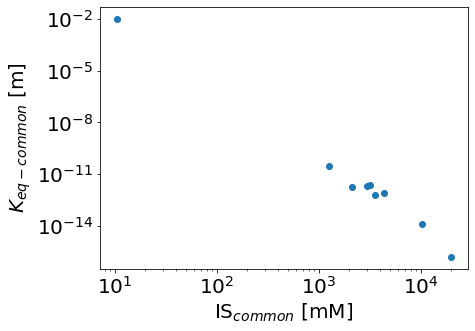

In [227]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('IS$_{common}$ [mM]')
ax.set_ylabel('$K_{eq-common}$ [m]')

ax.set_yscale('log')
ax.set_xscale('log')

ax.scatter(df_resin_corr['tis_common'], df_resin_corr['keq_common'])

# for i, icont in df_common_pts.iterrows():
#     ax.scatter([icont['tis_common']], [icont['keq_common']], label=icont['data_set'])
# ax.legend(loc='lower left', frameon=True, handlelength=0.1)

fig.savefig('./images/dephillips_data/meta_correlation_resins_common_points.png', dpi=300, 
            bbox='tight', transparent=False)

## Correlation of Keq predictions from the electrostatics model
Dimensional Keq in [m], like the data above

In [5]:
resins = ['caq', 'phq', 'pxq']
protein_list = ['adh', 'blg', 'cat', 'ova']

In [6]:
temp = []

for res in resins:
    df = pd.read_csv('ns_bim_spherical_pqr/Keq_predictions/Keq_predictions_' 
                     + res + '.csv')
    for protein in protein_list:
        df_temp = df[df['protein'] == protein].copy()
        df_temp.rename(columns={'IS(M)': 'IS (M)'}, inplace=True)
        keq_fit_params = optimize.curve_fit(my_fit_function_ln_keq_2, df_temp['IS (M)']*1e3,
                          np.log(df_temp['Keq']), p0=(1, -50), maxfev=10000)
        temp.append([res, protein, keq_fit_params[0][0], keq_fit_params[0][1]])

df_pred = pd.DataFrame(temp, columns=['resin', 'protein', 'a', 'b'])
df_pred

resin protein             a          b
0    caq     adh  4.319971e+29 -14.227802
1    caq     blg  1.691360e+26 -12.872592
2    caq     cat  1.039198e+57 -23.934073
3    caq     ova  7.946610e+13  -8.494552
4    phq     adh  1.351733e+26 -12.999022
5    phq     blg  1.343425e+23 -11.780349
6    phq     cat  5.587363e+50 -21.775438
7    phq     ova  5.196792e+11  -7.720421
8    pxq     adh  3.714454e+33 -15.596916
9    pxq     blg  4.745662e+29 -14.078795
10   pxq     cat  1.142448e+64 -26.335778
11   pxq     ova  2.281125e+16  -9.358341

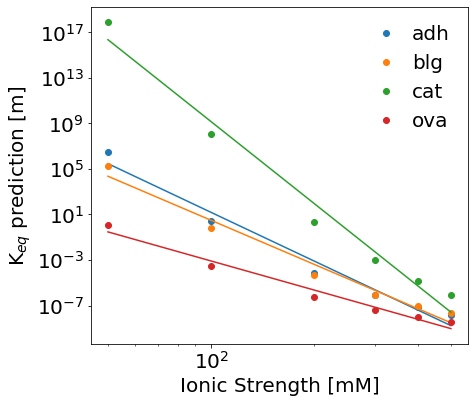

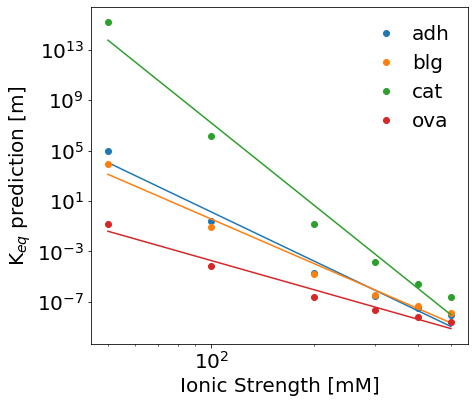

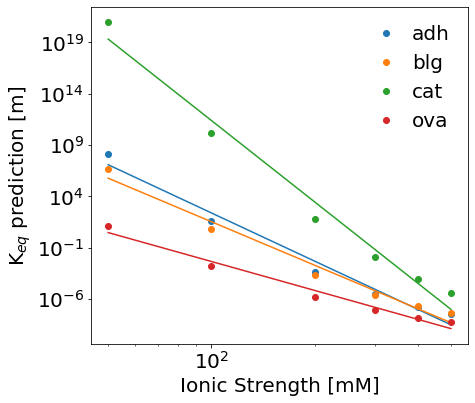

In [7]:
tis_new = np.linspace(50, 500, 1000)

for res in resins:
    df = pd.read_csv('ns_bim_spherical_pqr/Keq_predictions/Keq_predictions_' 
                     + res + '.csv')

    params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6, forward=True)
    ax.set_xlabel('Ionic Strength [mM]')
    ax.set_ylabel(r'K$_{eq}$ prediction [m]')
    
    for protein in protein_list:
        df_temp = df[df['protein'] == protein].copy()
        df_temp.rename(columns={'IS(M)': 'IS (M)'}, inplace=True)
        df_pred_temp = df_pred[(df_pred['protein'] == protein) &
                               (df_pred['resin'] == res)].copy()
        df_pred_temp.reset_index(inplace=True)
        
        keq_new = [np.exp(my_fit_function_ln_keq_2(tis, df_pred_temp.at[0, 'a'],
                   df_pred_temp.at[0, 'b'])) for tis in tis_new]

        ax.loglog(df_temp['IS (M)']*1e3, df_temp['Keq'], 'o', label=protein)
        ax.loglog(tis_new, keq_new, color=plt.gca().lines[-1].get_color())

    ax.legend(loc='best', frameon=False, handlelength=1.0)
#     fig.savefig('./images/Keq_pred_lin_correlation/' + res + '.png', dpi=300, 
#             bbox='tight', transparent=False)

### Meta-correlation of dimensional Keq data, predicted and experimental

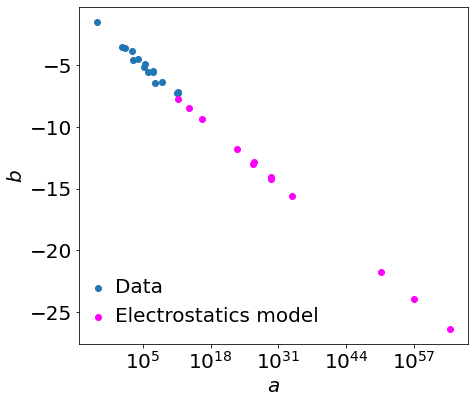

In [24]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 6, forward=True)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

ax.scatter(df_dim_Keq['a'], df_dim_Keq['b'], label='Data')
ax.scatter(df_pred['a'], df_pred['b'], label='Electrostatics model', color='magenta')

# ax.text(x=1e15, y=-25, s=r'$K_{eq} = a \: (IS)^b$')
ax.set_xscale('log')
# ax.set_xlim(1e5, 1e70)

ax.legend(handlelength=0.1, frameon=False, loc='lower left')
fig.patch.set_alpha(1)
plt.tight_layout()
fig.savefig('./images/meta_correlation_electrostatics_model.png', dpi=300)

## Correlation of dimensionless Keq data fit in CADET
(Keq values that were fit to raw data chromatograms in CADET)

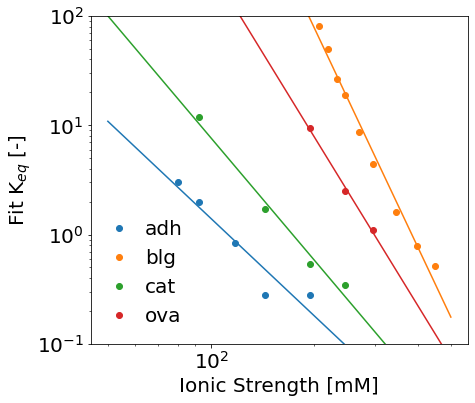

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  


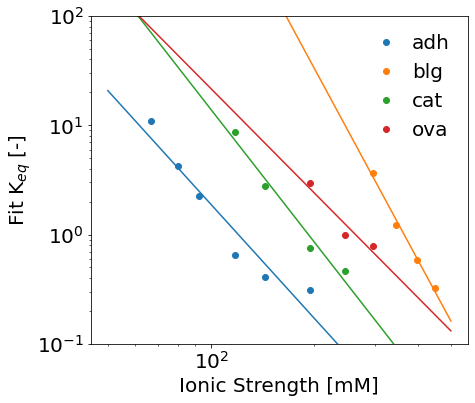

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  


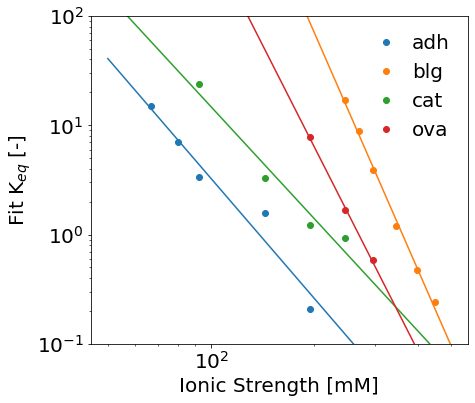

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  


In [34]:
fit_params = {}

for res in resins:
    fit_params[res], fig = plot_keq(res, my_fit_function_ln_keq_2)
    fig.savefig('./images/Keq_dimensionless_data_lin_correlation/' + res + '.png', dpi=300, 
                bbox='tight', transparent=False)

In [35]:
temp = []

for res in resins:
    for i, protein in enumerate(protein_list):
        temp.append([res, protein, fit_params[res][i][0], fit_params[res][i][1]])
        
df_data = pd.DataFrame(temp, columns=['resin', 'protein', 'a', 'b'])
df_data

resin protein             a         b
0    caq     adh  1.148343e+06 -2.956956
1    caq     blg  1.503032e+17 -6.643883
2    caq     cat  2.032629e+08 -3.712540
3    caq     ova  4.524316e+12 -5.112185
4    phq     adh  1.572825e+07 -3.460761
5    phq     blg  7.546673e+14 -5.805253
6    phq     cat  1.567278e+09 -4.026235
7    phq     ova  4.671602e+07 -3.167861
8    pxq     adh  6.344808e+07 -3.644913
9    pxq     blg  2.353731e+18 -7.181693
10   pxq     cat  9.395301e+07 -3.401990
11   pxq     ova  1.034302e+15 -6.177113

### Meta-correlation of dimensionless Keq data

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


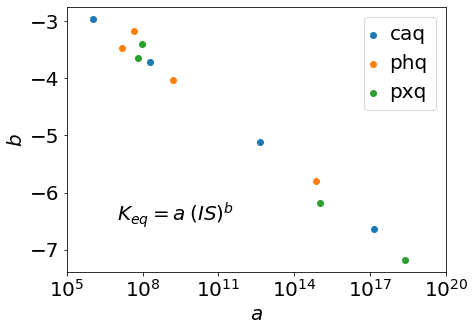

In [36]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

for res in resins:
    df = df_data[df_data['resin'] == res].copy()
    ax.scatter(df['a'], df['b'], label=res)

ax.text(x=1e7, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
ax.set_xscale('log')
ax.set_xlim(1e5, 1e20)
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_a_vs_b.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


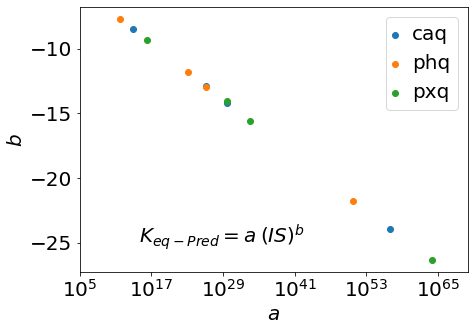

In [37]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

for res in resins:
    df = df_pred[df_pred['resin'] == res].copy()
    ax.scatter(df['a'], df['b'], label=res)

ax.text(x=1e15, y=-25, s=r'$K_{eq-Pred} = a \: (IS)^b$')
ax.set_xscale('log')
ax.set_xlim(1e5, 1e70)

ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/predictions_a_vs_b.png', dpi=300, 
            bbox='tight', transparent=False)

In [38]:
meta_fit = optimize.curve_fit(meta_correlation, df_data['a'], df_data['b'], 
                             p0=(-1.0, -1.0), maxfev=10000)

In [39]:
a_vals = np.logspace(5, 20, 1000)
b_vals = [meta_correlation(a, meta_fit[0][0], meta_fit[0][1]) for a in a_vals]

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


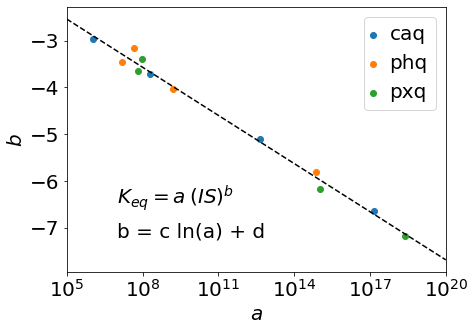

In [40]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

for res in resins:
    df = df_data[df_data['resin'] == res].copy()
    ax.scatter(df['a'], df['b'], label=res)

ax.plot(a_vals, b_vals, linestyle='--', color='black')

ax.text(x=1e7, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
ax.text(x=1e7, y=-7.2, s='b = c ln(a) + d')
ax.set_xscale('log')
ax.set_xlim(1e5, 1e20)
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_a_vs_b_meta_correlation.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


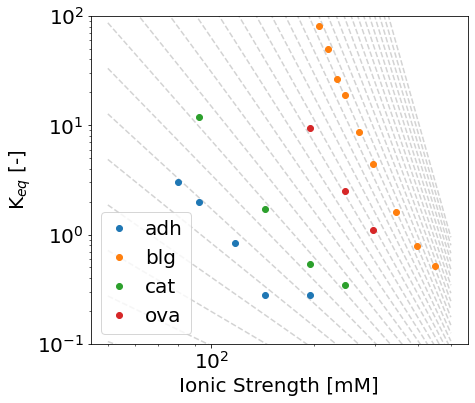

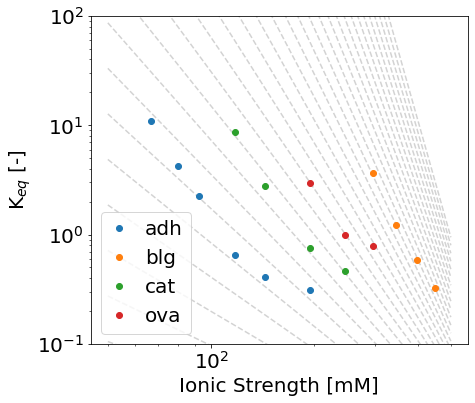

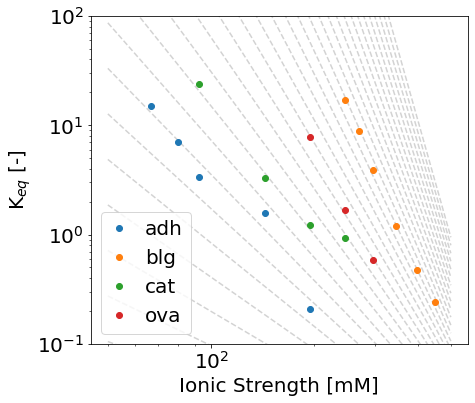

In [42]:
for resin in resins:
    
    params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    fig.patch.set_alpha(1.0)
    fig.set_size_inches(7, 6, forward=True)
    ax.set_xlabel('Ionic Strength [mM]')
    ax.set_ylabel(r'K$_{eq}$ [-]')
    ax.set_ylim(0.1, 100)

    a_vals = np.logspace(1, 30, 30)
    tis_new = np.linspace(50, 500, 1000)

    for a in a_vals:
        b = meta_correlation(a, meta_fit[0][0], meta_fit[0][1])
        keq = [a*tis**b for tis in tis_new]
        ax.loglog(tis_new, keq, '--', color='lightgrey')

    for i, protein in enumerate(protein_list):
        df = get_fit_params(protein, resin)
        ax.loglog(df['IS (M)']*1e3, df['Keq'], 'o', label=protein)

    ax.legend(loc='lower left', frameon=True, handlelength=1.0)
    fig.savefig('./images/meta_lin_correlation/dimensionless_' + resin + '_data.png', dpi=300, 
                bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


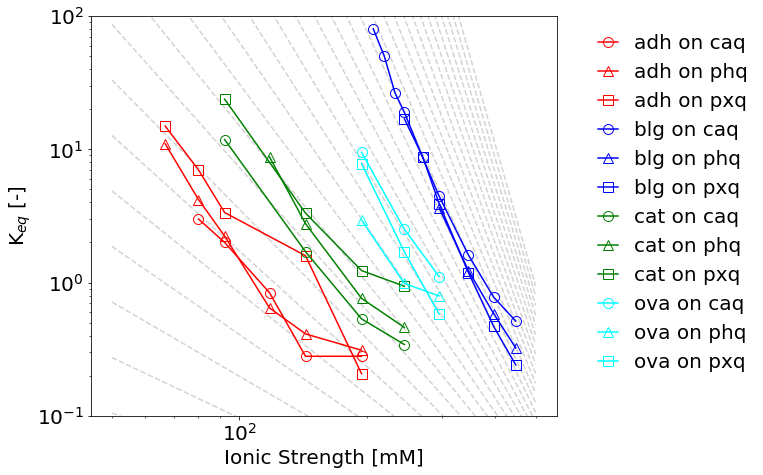

In [43]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(11, 7, forward=True)
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel(r'K$_{eq}$ [-]')
ax.set_ylim(0.1, 100)

a_vals = np.logspace(1, 30, 30)
tis_new = np.linspace(50, 500, 1000)

for a in a_vals:
    b = meta_correlation(a, meta_fit[0][0], meta_fit[0][1])
    keq = [a*tis**b for tis in tis_new]
    ax.loglog(tis_new, keq, '--', color='lightgrey')

for j, protein in enumerate(protein_list):
    if j == 0:
        color = 'red'
    elif j == 1:
        color = 'blue'
    elif j == 2:
        color = 'green'
    elif j == 3:
        color = 'cyan'
    
    for i, resin in enumerate(resins):
        if i == 0:
            symbol = 'o'
        elif i == 1:
            symbol = '^'
        elif i == 2:
            symbol = 's'        
        
        df = get_fit_params(protein, resin)
        ax.loglog(df['IS (M)']*1e3, df['Keq'], marker=symbol, color=color, 
                  fillstyle='none', markersize=10, label=f'{protein} on {resin}')

ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=False, handlelength=1.0)
fig.savefig('./images/meta_lin_correlation/all_dimensionless_data.png', dpi=300, 
            bbox='tight', transparent=False)

# Correlation of the 'a' and 'b' parameters in the linear model with protein characteristics

## Dimensional Keq data (from k' conversions)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


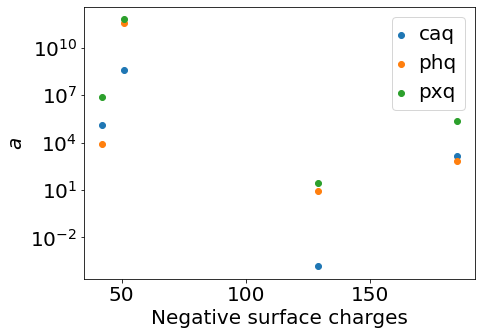

In [22]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative surface charges')
ax.set_ylabel('$a$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(num_surf, df['a'], label=res)

ax.set_yscale('log')
# ax.set_xlim(0, 200)
# ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_dim_a_vs_negative_surf_charges.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


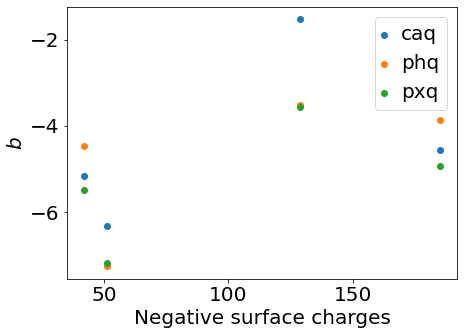

In [23]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative surface charges')
ax.set_ylabel('$b$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(num_surf, df['b'], label=res)

# ax.set_xlim(0, 200)
# ax.text(x=75, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_dim_b_vs_negative_surf_charges.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


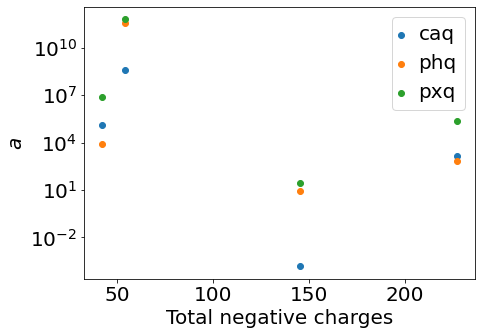

In [24]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Total negative charges')
ax.set_ylabel('$a$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(total_neg, df['a'], label=res)

ax.set_yscale('log')
# ax.set_xlim(0, 250)
# ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_dim_a_vs_total_negative_charges.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


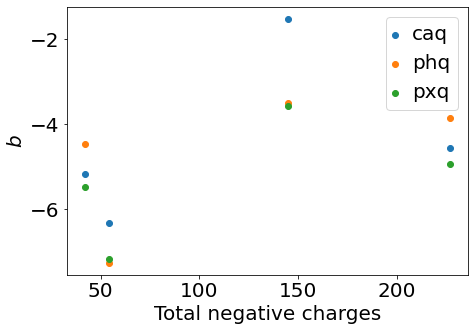

In [141]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Total negative charges')
ax.set_ylabel('$b$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(total_neg, df['b'], label=res)

# ax.set_xlim(0, 250)
# ax.text(x=75, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_dim_b_vs_total_negative_charges.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


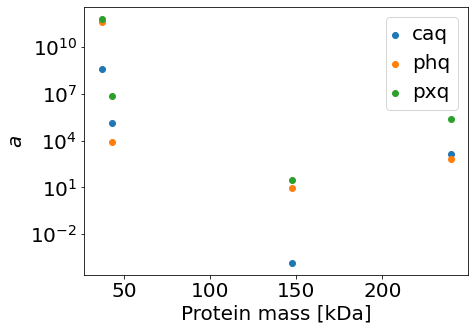

In [142]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('Protein mass [kDa]')
ax.set_ylabel('$a$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(masses, df['a'], label=res)

ax.set_yscale('log')
# ax.set_xlim(0, 250)
# ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_dim_a_vs_protein_masses.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


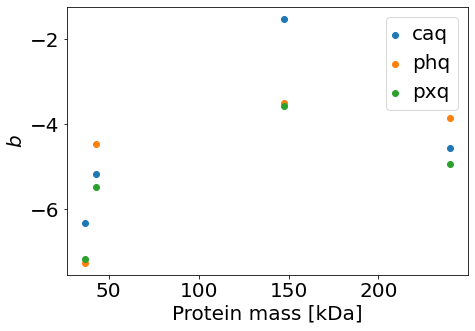

In [143]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('Protein mass [kDa]')
ax.set_ylabel('$b$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(masses, df['b'], label=res)

# ax.set_xlim(0, 250)
# ax.text(x=75, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_dim_b_vs_protein_masses.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


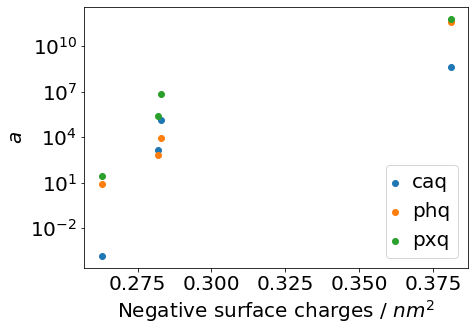

In [144]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative surface charges / $nm^2$')
ax.set_ylabel('$a$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(np.array(num_surf_per_area)*100, df['a'], label=res)

ax.set_yscale('log')
# ax.set_xlim(0, 200)
# ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_dim_a_vs_negative_surf_charges_per_area.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


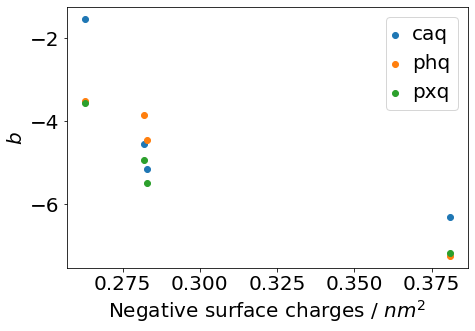

In [145]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative surface charges / $nm^2$')
ax.set_ylabel('$b$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(np.array(num_surf_per_area)*100, df['b'], label=res)

# ax.set_yscale('log')
# ax.set_xlim(0, 200)
# ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_dim_b_vs_negative_surf_charges_per_area.png', dpi=300, 
            bbox='tight', transparent=False)

In [ ]:
(total_charge, mod_total_charge, total_charge_per_area, mod_total_charge_per_area)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


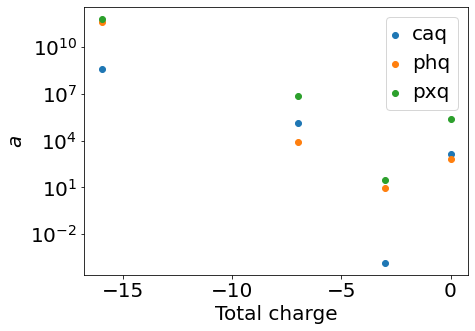

In [49]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Total charge')
ax.set_ylabel('$a$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(total_charge, df['a'], label=res)

ax.set_yscale('log')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/Keq_dimensional_lin_correlation/total_charge_a.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


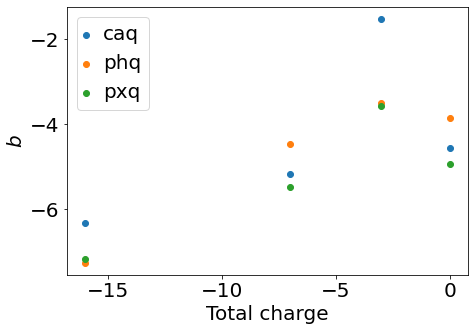

In [54]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Total charge')
ax.set_ylabel('$b$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(total_charge, df['b'], label=res)

ax.legend(loc='upper left', handlelength=0.1, frameon=True)
fig.savefig('./images/Keq_dimensional_lin_correlation/total_charge_b.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


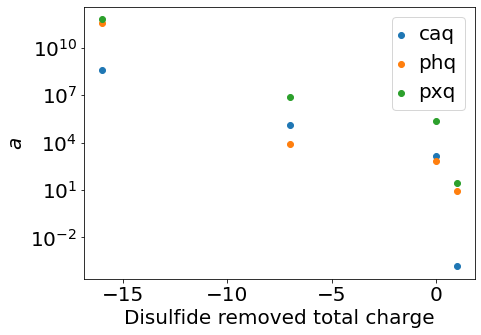

In [26]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Disulfide removed total charge')
ax.set_ylabel('$a$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(mod_total_charge, df['a'], label=res)

ax.set_yscale('log')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/Keq_dimensional_lin_correlation/sulfide_removed_total_charge_a.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


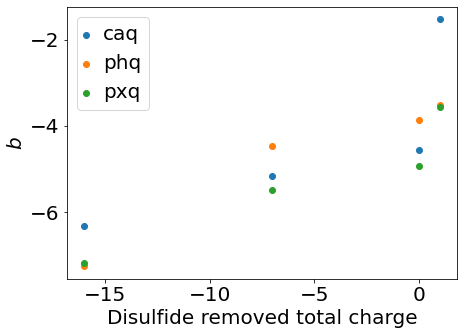

In [27]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Disulfide removed total charge')
ax.set_ylabel('$b$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(mod_total_charge, df['b'], label=res)

ax.legend(loc='upper left', handlelength=0.1, frameon=True)
fig.savefig('./images/Keq_dimensional_lin_correlation/sulfide_removed_total_charge_b.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


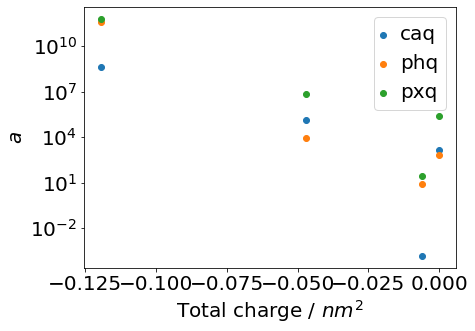

In [62]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Total charge / $nm^2$')
ax.set_ylabel('$a$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(total_charge_per_area*100, df['a'], label=res)

ax.set_yscale('log')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/Keq_dimensional_lin_correlation/total_charge_per_area_a.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


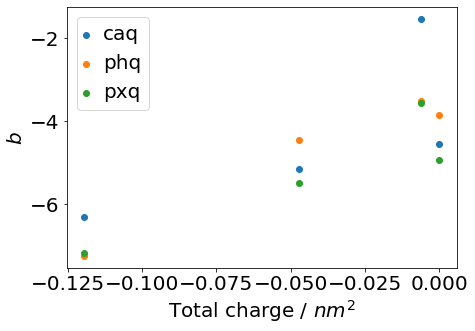

In [63]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Total charge / $nm^2$')
ax.set_ylabel('$b$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(total_charge_per_area*100, df['b'], label=res)

ax.legend(loc='upper left', handlelength=0.1, frameon=True)
fig.savefig('./images/Keq_dimensional_lin_correlation/total_charge_per_area_b.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


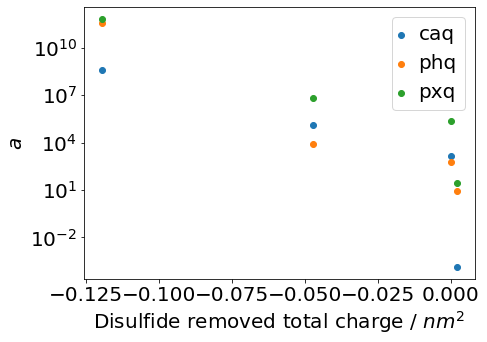

In [28]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Disulfide removed total charge / $nm^2$')
ax.set_ylabel('$a$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(mod_total_charge_per_area*100, df['a'], label=res)

ax.set_yscale('log')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/Keq_dimensional_lin_correlation/sulfide_removed_total_charge_per_area_a.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


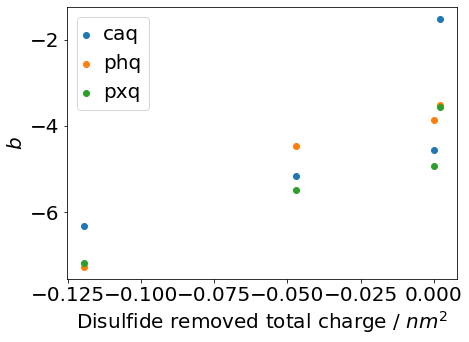

In [29]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Disulfide removed total charge / $nm^2$')
ax.set_ylabel('$b$')

for res in resins:
    df = df_dim_Keq[df_dim_Keq['resin'] == res].copy()
    ax.scatter(mod_total_charge_per_area*100, df['b'], label=res)

ax.legend(loc='upper left', handlelength=0.1, frameon=True)
fig.savefig('./images/Keq_dimensional_lin_correlation/sulfide_removed_total_charge_per_area_b.png', dpi=300, 
            bbox='tight', transparent=False)

## Predictions from electrostatics model (of dimensional Keq)


In [421]:
df_pred

resin protein             a          b
0    caq     adh  4.319971e+29 -14.227802
1    caq     blg  1.691360e+26 -12.872592
2    caq     cat  1.039199e+57 -23.934073
3    caq     ova  7.946608e+13  -8.494551
4    phq     adh  1.351733e+26 -12.999022
5    phq     blg  1.343425e+23 -11.780349
6    phq     cat  5.587359e+50 -21.775438
7    phq     ova  5.196792e+11  -7.720421
8    pxq     adh  3.714454e+33 -15.596916
9    pxq     blg  4.745662e+29 -14.078795
10   pxq     cat  1.142448e+64 -26.335778
11   pxq     ova  2.281120e+16  -9.358341

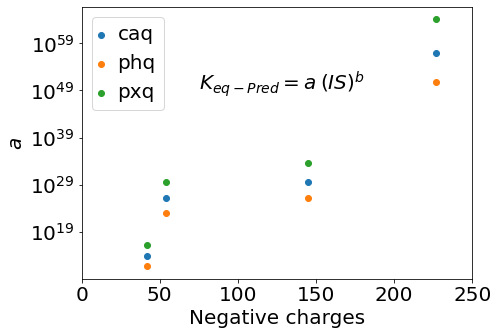

In [52]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative charges')
ax.set_ylabel('$a$')

for res in resins:
    df = df_pred[df_pred['resin'] == res].copy()
    ax.scatter(total_neg, df['a'], label=res)

ax.set_yscale('log')
ax.set_xlim(0, 250)
ax.text(x=75, y=1e49, s=r'$K_{eq-Pred} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/predictions_a_vs_total_negative_charges.png', dpi=300, transparent=False)

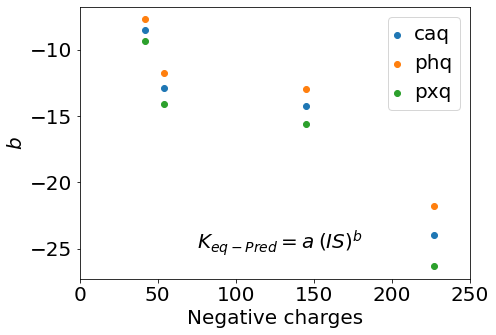

In [53]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative charges')
ax.set_ylabel('$b$')

for res in resins:
    df = df_pred[df_pred['resin'] == res].copy()
    ax.scatter(total_neg, df['b'], label=res)

ax.set_xlim(0, 250)
ax.text(x=75, y=-25, s=r'$K_{eq-Pred} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/predictions_b_vs_total_negative_charges.png', dpi=300)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


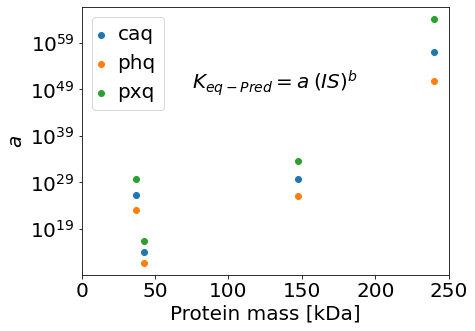

In [456]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('Protein mass [kDa]')
ax.set_ylabel('$a$')

for res in resins:
    df = df_pred[df_pred['resin'] == res].copy()
    ax.scatter(masses, df['a'], label=res)

ax.set_yscale('log')
ax.set_xlim(0, 250)
ax.text(x=75, y=1e49, s=r'$K_{eq-Pred} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/predictions_a_vs_protein_masses.png', dpi=300, 
            bbox='tight', transparent=False)

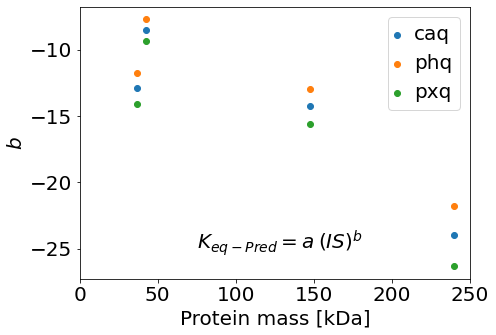

In [44]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('Protein mass [kDa]')
ax.set_ylabel('$b$')

for res in resins:
    df = df_pred[df_pred['resin'] == res].copy()
    ax.scatter(masses, df['b'], label=res)

ax.set_xlim(0, 250)
ax.text(x=75, y=-25, s=r'$K_{eq-Pred} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/predictions_b_vs_protein_masses.png', dpi=300, transparent=False)

In [33]:
ns_bim_radii = [3.5723, 2.219, 4.0709, 2.3383] # nm
sphere_areas = [4.0/3.0*np.pi*r**3 for r in ns_bim_radii]

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


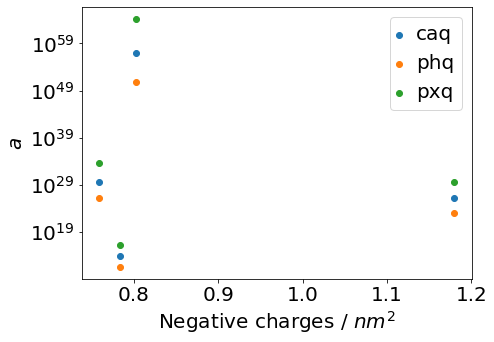

In [45]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative charges / $nm^2$')
ax.set_ylabel('$a$')

for res in resins:
    df = df_pred[df_pred['resin'] == res].copy()
    ax.scatter(np.array(total_neg)/np.array(sphere_areas), df['a'], label=res)

ax.set_yscale('log')
# ax.set_xlim(0, 200)
# ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/prediction_a_vs_negative_charge_per_area.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


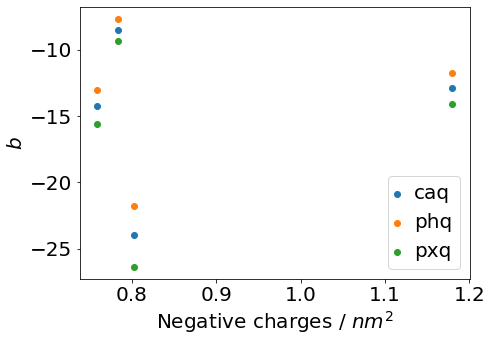

In [46]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative charges / $nm^2$')
ax.set_ylabel('$b$')

for res in resins:
    df = df_pred[df_pred['resin'] == res].copy()
    ax.scatter(np.array(total_neg)/np.array(sphere_areas), df['b'], label=res)

# ax.set_yscale('log')
# ax.set_xlim(0, 200)
# ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/prediction_b_vs_negative_charge_per_area.png', dpi=300, 
            bbox='tight', transparent=False)

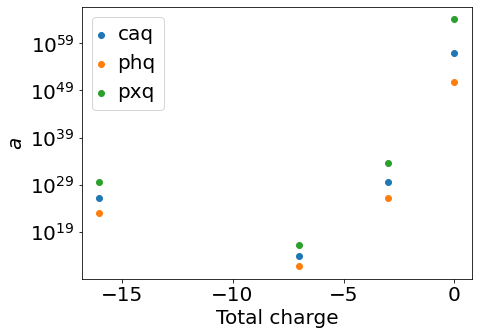

In [48]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Total charge')
ax.set_ylabel('$a$')

for res in resins:
    df = df_pred[df_pred['resin'] == res].copy()
    ax.scatter(total_charge, df['a'], label=res)

ax.set_yscale('log')
# ax.set_xlim(0, 200)
# ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/prediction_a_vs_total_charge.png', dpi=300, transparent=False)

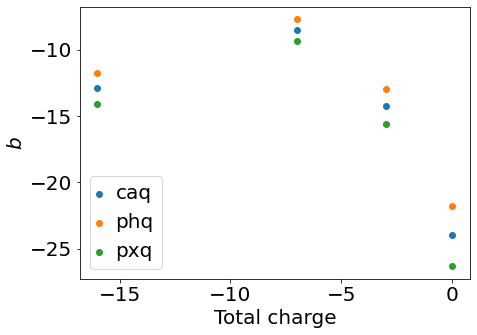

In [50]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Total charge')
ax.set_ylabel('$b$')

for res in resins:
    df = df_pred[df_pred['resin'] == res].copy()
    ax.scatter(total_charge, df['b'], label=res)

# ax.set_yscale('log')
# ax.set_xlim(0, 200)
# ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True, loc='lower left')
fig.savefig('./images/prediction_b_vs_total_charge.png', dpi=300, transparent=False)

## Correlation - dimensionless Keq fit in CADET

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


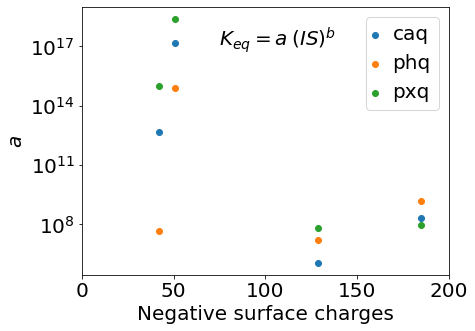

In [387]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative surface charges')
ax.set_ylabel('$a$')

for res in resins:
    df = df_data[df_data['resin'] == res].copy()
    ax.scatter(num_surf, df['a'], label=res)

ax.set_yscale('log')
ax.set_xlim(0, 200)
ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_a_vs_negative_surf_charges.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


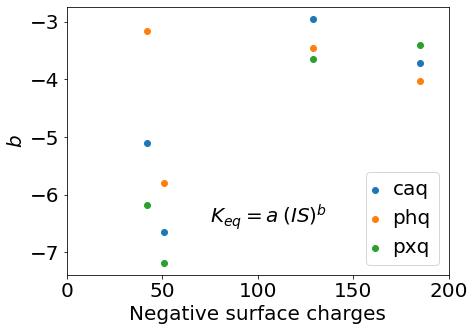

In [382]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative surface charges')
ax.set_ylabel('$b$')

for res in resins:
    df = df_data[df_data['resin'] == res].copy()
    ax.scatter(num_surf, df['b'], label=res)

ax.set_xlim(0, 200)
ax.text(x=75, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_b_vs_negative_surf_charges.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


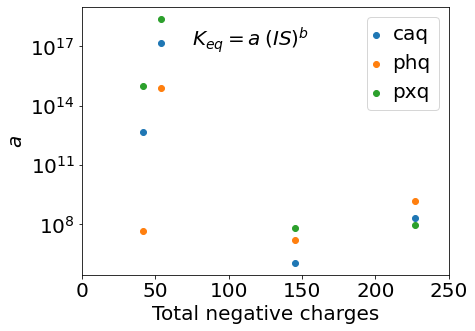

In [388]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Total negative charges')
ax.set_ylabel('$a$')

for res in resins:
    df = df_data[df_data['resin'] == res].copy()
    ax.scatter(total_neg, df['a'], label=res)

ax.set_yscale('log')
ax.set_xlim(0, 250)
ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_a_vs_total_negative_charges.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


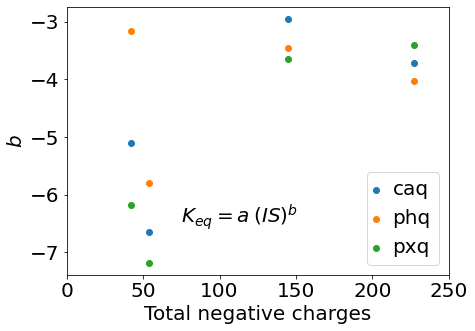

In [389]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Total negative charges')
ax.set_ylabel('$b$')

for res in resins:
    df = df_data[df_data['resin'] == res].copy()
    ax.scatter(total_neg, df['b'], label=res)

ax.set_xlim(0, 250)
ax.text(x=75, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_b_vs_total_negative_charges.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


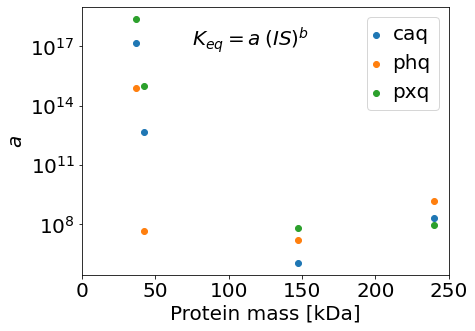

In [402]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('Protein mass [kDa]')
ax.set_ylabel('$a$')

for res in resins:
    df = df_data[df_data['resin'] == res].copy()
    ax.scatter(masses, df['a'], label=res)

ax.set_yscale('log')
ax.set_xlim(0, 250)
ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_a_vs_protein_masses.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


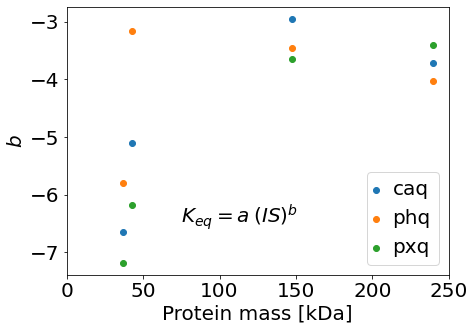

In [435]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel('Protein mass [kDa]')
ax.set_ylabel('$b$')

for res in resins:
    df = df_data[df_data['resin'] == res].copy()
    ax.scatter(masses, df['b'], label=res)

ax.set_xlim(0, 250)
ax.text(x=75, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_b_vs_protein_masses.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


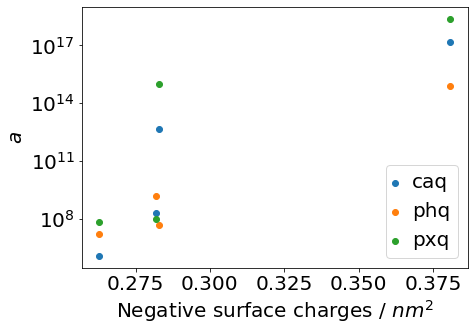

In [126]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative surface charges / $nm^2$')
ax.set_ylabel('$a$')

for res in resins:
    df = df_data[df_data['resin'] == res].copy()
    ax.scatter(np.array(num_surf_per_area)*100, df['a'], label=res)

ax.set_yscale('log')
# ax.set_xlim(0, 200)
# ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_a_vs_negative_surf_charges_per_area.png', dpi=300, 
            bbox='tight', transparent=False)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


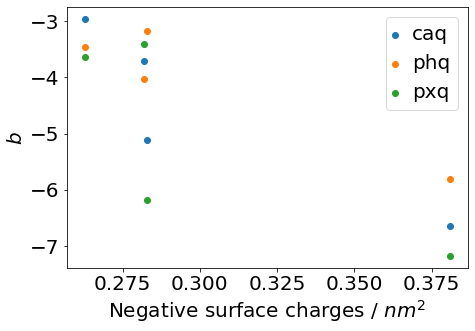

In [125]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Negative surface charges / $nm^2$')
ax.set_ylabel('$b$')

for res in resins:
    df = df_data[df_data['resin'] == res].copy()
    ax.scatter(np.array(num_surf_per_area)*100, df['b'], label=res)

# ax.set_yscale('log')
# ax.set_xlim(0, 200)
# ax.text(x=75, y=1e17, s=r'$K_{eq} = a \: (IS)^b$')
ax.legend(handlelength=0.1, frameon=True)
fig.savefig('./images/data_b_vs_negative_surf_charges_per_area.png', dpi=300, 
            bbox='tight', transparent=False)

# Data and correlations using the 2-parameter 'linear' model - replotted
## Experimental (dimensional) Keq data (converting k' with phase ratios)
These data are from converting k' to Keq using protein-resin combination specific phase ratios. The Keq data are in [m]

In [96]:
dimensional_Keq_files = os.listdir('./experimental_data_kprime')

In [97]:
dim_Keq = {}
for f in dimensional_Keq_files:
    dim_Keq[f] = pd.read_csv('./experimental_data_kprime/' + f)

In [98]:
temp = []

for f in dimensional_Keq_files:
    df = dim_Keq[f]
    keq_fit_params = optimize.curve_fit(my_fit_function_ln_keq_2, df['IS(M)']*1e3,
                      np.log(df['Keq']), p0=(1, -50), maxfev=10000)
    temp.append([f, keq_fit_params[0][0], keq_fit_params[0][1]])

df_dim_Keq = pd.DataFrame(temp, columns=['file', 'a', 'b'])
# df_dim_Keq

/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [99]:
resins = ['caq', 'phq', 'pxq']

for i, icont in df_dim_Keq.iterrows():
    f = icont['file']
    df_dim_Keq.at[i, 'protein'] = f[:f.find('_')]
    df_dim_Keq.at[i, 'resin'] = f[f.find('_')+1:f.find('_')+4]
    df_dim_Keq.at[i, 'pH'] = f[f.find('.')-1]

df_dim_Keq.sort_values(by=['resin', 'protein', 'pH'], inplace=True)
df_dim_Keq.reset_index(drop=True, inplace=True)
# df_dim_Keq

In [100]:
# all_resins = ['caq', 'phq', 'pxq', 'sep']
# tis_new = np.linspace(50, 500, 1000)

# for res in all_resins:
#     params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
#     plt.rcParams.update(params)
#     fig, ax = plt.subplots()
#     fig.set_size_inches(7, 6, forward=True)
#     fig.patch.set_alpha(1.0)
#     ax.set_xlabel('Ionic Strength [mM]')
#     ax.set_ylabel(r'K$_{eq}$ [m]')
#     ax.set_ylim(1e-9, 1e-4)
    
#     df_params = df_dim_Keq[df_dim_Keq['resin'] == res]
#     for i, icont in df_params.iterrows():
#         df = dim_Keq[icont['file']]
#         label = icont['protein'] + ' pH ' + icont['pH']
#         ax.loglog(df['IS(M)']*1e3, df['Keq'], 'o', label=label)

#         a = icont['a']
#         b = icont['b']
#         keq_new = [np.exp(my_fit_function_ln_keq_2(tis, a, b)) for tis in tis_new]
#         ax.loglog(tis_new, keq_new, color=plt.gca().lines[-1].get_color())

#     ax.legend(loc='lower left', frameon=False, handlelength=1.0)
#     plt.tight_layout()
# #     fig.savefig('./images/Keq_dimensional_lin_correlation/' + res + '.png', dpi=300, 
# #             bbox='tight', transparent=False)


### Meta-correlation

In [101]:
meta_fit = optimize.curve_fit(meta_correlation, df_dim_Keq['a'], -1*df_dim_Keq['b'], 
                             p0=(-1.0, -1.0), maxfev=10000)
c, d = meta_fit[0][0], meta_fit[0][1]

In [102]:
c, d

(0.15913410323725133, 3.1203920350089063)

In [103]:
a_vals = np.logspace(-5, 13, 1000)
b_vals = [meta_correlation(a, meta_fit[0][0], meta_fit[0][1]) for a in a_vals]

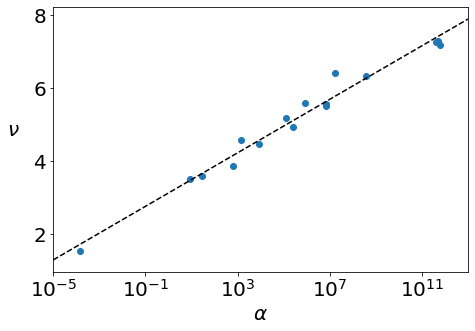

In [104]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.scatter(df_dim_Keq['a'], -1*df_dim_Keq['b'])
ax.plot(a_vals, b_vals, linestyle='--', color='black')

# ax.text(x=1e-4, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
# ax.text(x=1e-4, y=-7.2, s='b = c ln(a) + d')

ax.set_xscale('log')
ax.set_xlim(1e-5, 1e13)
plt.tight_layout()
fig.savefig('./images/manuscript_images/thermo_correlation_my_isocratic_data.pdf')

### Comparison of meta-correlation with experimental data in $K_{eq}$ - IS space

In [108]:
import matplotlib

In [109]:
df_dim_Keq.sort_values(by='protein', inplace=True)
df_dim_Keq.reset_index(inplace=True, drop=True)
df_dim_Keq
df_dim_Keq = pd.concat([df_dim_Keq.iloc[0:12], df_dim_Keq.iloc[13:], df_dim_Keq.iloc[[12]]])
df_dim_Keq.reset_index(inplace=True, drop=True)
df_dim_Keq

file             a         b protein resin pH
0     adh_caq_pH7.csv  1.442079e-04 -1.532384     adh   caq  7
1     adh_phq_pH7.csv  8.522910e+00 -3.515679     adh   phq  7
2     adh_pxq_pH7.csv  2.831660e+01 -3.573077     adh   pxq  7
3     blg_caq_pH7.csv  3.915647e+08 -6.326863     blg   caq  7
4     blg_phq_pH7.csv  3.892907e+11 -7.260876     blg   phq  7
5     blg_pxq_pH7.csv  6.223262e+11 -7.183929     blg   pxq  7
6     cat_caq_pH7.csv  1.335912e+03 -4.565047     cat   caq  7
7     cat_phq_pH7.csv  6.313490e+02 -3.856346     cat   phq  7
8     cat_pxq_pH7.csv  2.414861e+05 -4.932155     cat   pxq  7
9    lys_seph_pH5.csv  4.989469e+11 -7.280788     lys   sep  5
10   lys_seph_pH7.csv  7.189905e+06 -5.556522     lys   sep  7
11   lys_seph_pH9.csv  8.589650e+05 -5.587101     lys   sep  9
12    ova_caq_pH7.csv  1.280515e+05 -5.166430     ova   caq  7
13    ova_phq_pH7.csv  8.621266e+03 -4.465863     ova   phq  7
14    ova_pxq_pH7.csv  7.096002e+06 -5.491151     ova   pxq  7
15  mAbD_seph_pH7.csv  1.738005e+07 -6.408470    mAbD   sep  7

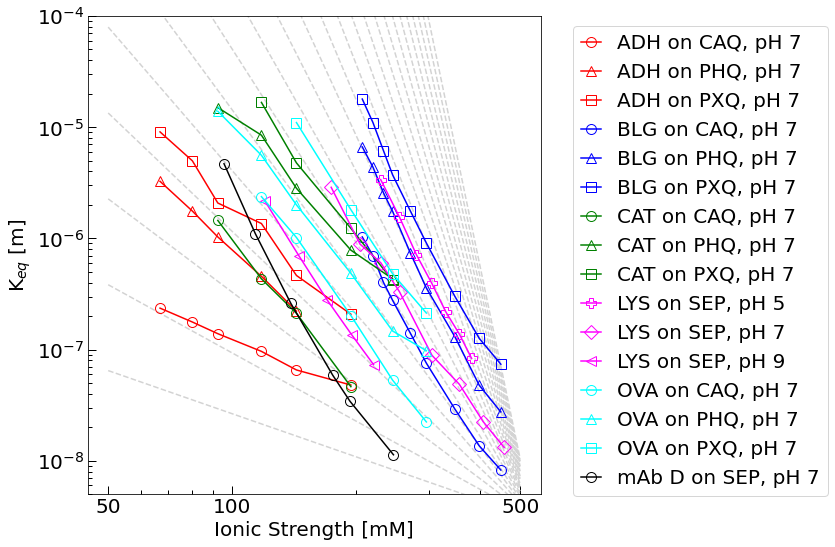

In [110]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(12, 8, forward=True)
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel(r'K$_{eq}$ [m]')
ax.set_ylim(5e-9, 1e-4)

a_vals = np.logspace(-5, 40, 23)
tis_new = np.linspace(50, 500, 1000)

for a in a_vals:
    b = meta_correlation(a, meta_fit[0][0], meta_fit[0][1])
    keq = [a*tis**(-1*b) for tis in tis_new]
    ax.loglog(tis_new, keq, '--', color='lightgrey')

for i, icont in df_dim_Keq.iterrows():
    df = dim_Keq[icont['file']]
    df.sort_values(by=['IS(M)'], inplace=True)
    protein, resin, pH = icont['protein'], icont['resin'], icont['pH']
    
    if protein=='mAbD':
        protein = 'mAb D'
    else:
        protein=protein.upper()
    label = f'{protein} on {resin.upper()}, pH {pH}'
    
    if icont['file'] == 'mAbD_seph_pH7.csv':
        ax.loglog(df['IS(M)']*1e3, df['Keq'], marker='o', fillstyle='none', markersize=10,
              label=label, color='black')
    else:
        protein, resin, pH = icont.protein, icont.resin, icont.pH
        
        if protein == 'adh':
            color = 'red'
        elif protein == 'blg':
            color = 'blue'
        elif protein == 'cat':
            color = 'green'
        elif protein == 'ova':
            color = 'cyan'
        else:
            color = 'magenta'
        
        if resin == 'caq':
            symbol = 'o'
        elif resin == 'phq':
            symbol = '^'
        elif resin == 'pxq':
            symbol = 's'  
        elif resin == 'sep':
            if pH == '5':
                symbol = 'P'
            elif pH == '7':
                symbol = 'D'
            elif pH == '9':
                symbol = '<'
            
        ax.loglog(df['IS(M)']*1e3, df['Keq'], marker=symbol, color=color, 
                  fillstyle='none', markersize=10, label=label)
        
ax.tick_params('both', length=8, width=1, which='major', direction='in')
ax.tick_params('both', length=4, width=1, which='minor', direction='in')

xticks = [50, 100, 500]
xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks)
xmajorFormatter = matplotlib.ticker.ScalarFormatter()
fig.gca().xaxis.set_major_locator( xmajorLocator )
fig.gca().xaxis.set_major_formatter( xmajorFormatter )
fig.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticklabels(xticks)

ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=True, handlelength=1.0)
plt.tight_layout()
# fig.savefig('./images/manuscript_images/thermo_correlation_my_isocratic_data_overlay_dimensional_Keq.pdf')

# Data and correlations using the 2-parameter 'linear' model - replotted
## Experimental *dimensionless* Keq data (converting k' with phase ratios)

In [49]:
files_Keq_nd = os.listdir('./dimensionless_Keq_1')
files_Keq_nd.remove('AEX_fit_porosities.xlsx')
files_Keq_nd.sort()
files_Keq_nd

['caq_adh_pH_7.csv',
 'caq_blg_pH_7.csv',
 'caq_cat_pH_7.csv',
 'caq_ova_pH_7.csv',
 'phq_adh_pH_7.csv',
 'phq_blg_pH_7.csv',
 'phq_cat_pH_7.csv',
 'phq_ova_pH_7.csv',
 'pxq_adh_pH_7.csv',
 'pxq_blg_pH_7.csv',
 'pxq_cat_pH_7.csv',
 'pxq_ova_pH_7.csv',
 'sep_lys_pH_5.csv',
 'sep_lys_pH_7.csv',
 'sep_lys_pH_9.csv',
 'sep_mAbD_pH_7.csv']

In [50]:
dim_Keq = {}
for f in files_Keq_nd:
    dim_Keq[f] = pd.read_csv('./dimensionless_Keq_1/' + f)

In [51]:
temp = []

for f in files_Keq_nd:
    df = dim_Keq[f]
    keq_fit_params = optimize.curve_fit(my_fit_function_ln_keq_2, df['IS (M)']*1e3,
                      np.log(df['Keq_nd']), p0=(1, -50), maxfev=10000)
    temp.append([f, keq_fit_params[0][0], keq_fit_params[0][1]])

df_dim_Keq = pd.DataFrame(temp, columns=['file', 'a', 'b'])
df_dim_Keq

file             a         b
0    caq_adh_pH_7.csv  3.841287e+03 -1.531318
1    caq_blg_pH_7.csv  2.050553e+16 -6.326865
2    caq_cat_pH_7.csv  1.406416e+12 -5.500367
3    caq_ova_pH_7.csv  6.133014e+12 -5.166430
4    phq_adh_pH_7.csv  3.191228e+07 -3.514624
5    phq_blg_pH_7.csv  3.639121e+18 -7.261087
6    phq_cat_pH_7.csv  1.325006e+09 -3.854670
7    phq_ova_pH_7.csv  6.850904e+10 -4.463772
8    pxq_adh_pH_7.csv  5.020307e+07 -3.571804
9    pxq_blg_pH_7.csv  3.457456e+18 -7.181837
10   pxq_cat_pH_7.csv  2.420133e+11 -4.933386
11   pxq_ova_pH_7.csv  3.322442e+13 -5.493056
12   sep_lys_pH_5.csv  1.713166e+20 -7.284316
13   sep_lys_pH_7.csv  2.450275e+15 -5.558835
14   sep_lys_pH_9.csv  2.850076e+14 -5.584334
15  sep_mAbD_pH_7.csv  2.259925e+15 -6.408470

In [52]:
resins = ['caq', 'phq', 'pxq']

for i, icont in df_dim_Keq.iterrows():
    f = icont['file']
    df_dim_Keq.at[i, 'resin'] = f[:f.find('_')]
    df_dim_Keq.at[i, 'protein'] = f[f.find('_')+1:f.find('_')+4]
    df_dim_Keq.at[i, 'pH'] = f[f.find('.')-1]

df_dim_Keq.sort_values(by=['resin', 'protein', 'pH'], inplace=True)
df_dim_Keq.reset_index(drop=True, inplace=True)
df_dim_Keq

file             a         b resin protein pH
0    caq_adh_pH_7.csv  3.841287e+03 -1.531318   caq     adh  7
1    caq_blg_pH_7.csv  2.050553e+16 -6.326865   caq     blg  7
2    caq_cat_pH_7.csv  1.406416e+12 -5.500367   caq     cat  7
3    caq_ova_pH_7.csv  6.133014e+12 -5.166430   caq     ova  7
4    phq_adh_pH_7.csv  3.191228e+07 -3.514624   phq     adh  7
5    phq_blg_pH_7.csv  3.639121e+18 -7.261087   phq     blg  7
6    phq_cat_pH_7.csv  1.325006e+09 -3.854670   phq     cat  7
7    phq_ova_pH_7.csv  6.850904e+10 -4.463772   phq     ova  7
8    pxq_adh_pH_7.csv  5.020307e+07 -3.571804   pxq     adh  7
9    pxq_blg_pH_7.csv  3.457456e+18 -7.181837   pxq     blg  7
10   pxq_cat_pH_7.csv  2.420133e+11 -4.933386   pxq     cat  7
11   pxq_ova_pH_7.csv  3.322442e+13 -5.493056   pxq     ova  7
12   sep_lys_pH_5.csv  1.713166e+20 -7.284316   sep     lys  5
13   sep_lys_pH_7.csv  2.450275e+15 -5.558835   sep     lys  7
14   sep_lys_pH_9.csv  2.850076e+14 -5.584334   sep     lys  9
15  sep_mAbD_pH_7.csv  2.259925e+15 -6.408470   sep     mAb  7

### Meta-correlation

In [53]:
meta_fit = optimize.curve_fit(meta_correlation, df_dim_Keq['a'], -1*df_dim_Keq['b'], 
                             p0=(-1.0, -1.0), maxfev=10000)
c, d = meta_fit[0][0], meta_fit[0][1]

In [54]:
c, d

(0.1479314899082261, 0.8111714806909207)

In [55]:
a_vals = np.logspace(1, 22, 1000)
b_vals = [meta_correlation(a, meta_fit[0][0], meta_fit[0][1]) for a in a_vals]

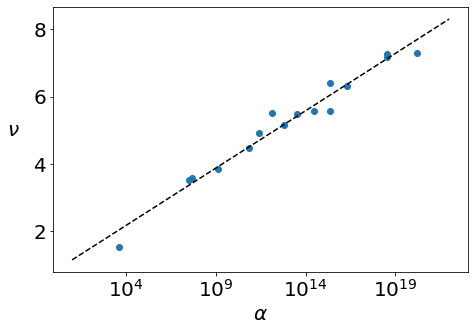

In [56]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.scatter(df_dim_Keq['a'], -1*df_dim_Keq['b'])
ax.plot(a_vals, b_vals, linestyle='--', color='black')

# ax.text(x=1e-4, y=-6.5, s=r'$K_{eq} = a \: (IS)^b$')
# ax.text(x=1e-4, y=-7.2, s='b = c ln(a) + d')

ax.set_xscale('log')
# ax.set_xlim(1e-5, 1e13)
plt.tight_layout()
# fig.savefig('./images/manuscript_images/thermo_correlation_my_isocratic_data.pdf')

### Comparison of meta-correlation with experimental data in $K_{eq}$ - IS space

In [57]:
import matplotlib

In [58]:
df_dim_Keq.sort_values(by='protein', inplace=True)
df_dim_Keq.reset_index(inplace=True, drop=True)
df_dim_Keq
df_dim_Keq = pd.concat([df_dim_Keq.iloc[0:12], df_dim_Keq.iloc[13:], df_dim_Keq.iloc[[12]]])
df_dim_Keq.reset_index(inplace=True, drop=True)
df_dim_Keq

file             a         b resin protein pH
0    caq_adh_pH_7.csv  3.841287e+03 -1.531318   caq     adh  7
1    phq_adh_pH_7.csv  3.191228e+07 -3.514624   phq     adh  7
2    pxq_adh_pH_7.csv  5.020307e+07 -3.571804   pxq     adh  7
3    caq_blg_pH_7.csv  2.050553e+16 -6.326865   caq     blg  7
4    phq_blg_pH_7.csv  3.639121e+18 -7.261087   phq     blg  7
5    pxq_blg_pH_7.csv  3.457456e+18 -7.181837   pxq     blg  7
6    caq_cat_pH_7.csv  1.406416e+12 -5.500367   caq     cat  7
7    phq_cat_pH_7.csv  1.325006e+09 -3.854670   phq     cat  7
8    pxq_cat_pH_7.csv  2.420133e+11 -4.933386   pxq     cat  7
9    sep_lys_pH_5.csv  1.713166e+20 -7.284316   sep     lys  5
10   sep_lys_pH_7.csv  2.450275e+15 -5.558835   sep     lys  7
11   sep_lys_pH_9.csv  2.850076e+14 -5.584334   sep     lys  9
12   caq_ova_pH_7.csv  6.133014e+12 -5.166430   caq     ova  7
13   phq_ova_pH_7.csv  6.850904e+10 -4.463772   phq     ova  7
14   pxq_ova_pH_7.csv  3.322442e+13 -5.493056   pxq     ova  7
15  sep_mAbD_pH_7.csv  2.259925e+15 -6.408470   sep     mAb  7

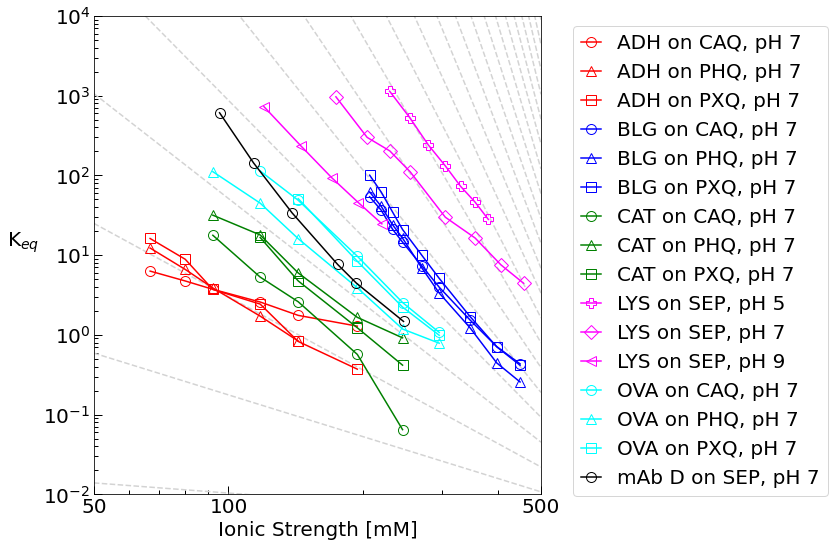

In [69]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.patch.set_alpha(1.0)
fig.set_size_inches(12, 8, forward=True)
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel(r'K$_{eq}$', rotation=0, labelpad=20)

a_vals = np.logspace(-5, 80, 23)
tis_new = np.linspace(50, 500, 1000)

for a in a_vals:
    b = meta_correlation(a, meta_fit[0][0], meta_fit[0][1])
    keq = [a*tis**(-1*b) for tis in tis_new]
    ax.loglog(tis_new, keq, '--', color='lightgrey')

for i, icont in df_dim_Keq.iterrows():
    df = dim_Keq[icont['file']]
    df.sort_values(by=['IS (M)'], inplace=True)
    protein, resin, pH = icont['protein'], icont['resin'], icont['pH']
    
    if protein=='mAb':
        protein = 'mAb D'
    else:
        protein=protein.upper()
    label = f'{protein} on {resin.upper()}, pH {pH}'
    
    if icont['file'] == 'sep_mAbD_pH_7.csv':
        ax.loglog(df['IS (M)']*1e3, df['Keq_nd'], marker='o', fillstyle='none', markersize=10,
              label=label, color='black')
    else:
        protein, resin, pH = icont.protein, icont.resin, icont.pH
        
        if protein == 'adh':
            color = 'red'
        elif protein == 'blg':
            color = 'blue'
        elif protein == 'cat':
            color = 'green'
        elif protein == 'ova':
            color = 'cyan'
        else:
            color = 'magenta'
        
        if resin == 'caq':
            symbol = 'o'
        elif resin == 'phq':
            symbol = '^'
        elif resin == 'pxq':
            symbol = 's'  
        elif resin == 'sep':
            if pH == '5':
                symbol = 'P'
            elif pH == '7':
                symbol = 'D'
            elif pH == '9':
                symbol = '<'
            
        ax.loglog(df['IS (M)']*1e3, df['Keq_nd'], marker=symbol, color=color, 
                  fillstyle='none', markersize=10, label=label)
        
ax.tick_params('both', length=8, width=1, which='major', direction='in')
ax.tick_params('both', length=4, width=1, which='minor', direction='in')

xticks = [50, 100, 500]
xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks)
xmajorFormatter = matplotlib.ticker.ScalarFormatter()
fig.gca().xaxis.set_major_locator( xmajorLocator )
fig.gca().xaxis.set_major_formatter( xmajorFormatter )
fig.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticklabels(xticks)

ax.set_ylim(1e-2, 1e4)
ax.set_xlim(50, 500)

ax.legend(bbox_to_anchor=(1.05, 1.0), frameon=True, handlelength=1.0)
plt.tight_layout()
fig.savefig('./images/manuscript_images/thermo_correlation_my_isocratic_data_overlay.pdf')